****
# **Latar Belakang**
****

Sebuah perusahaan baru yang bergerak dibidang pengelolaan transportasi umum yakni Green Taxi sedang giat dalam mengembangkan bisnisnya. Oleh karena itu, tim marketing meminta bantuan tim data analyst untuk mengeksplore informasi yang dapat membantu meningkatkan strategi pemasaran yang lebih efektif dan efisien.

****
# **Pernyataan Masalah**
****

Perusahaan ingin mengetahui **bagaimana karakteristik dari penumpang taxi** selama satu bulan terakhir. Informasi ini akan membantu perusahaan memahami profil pelanggan mereka secara lebih baik yang berguna untuk meningkatkan profit. 

****
# **Pertanyaan**
****
1. Daerah mana yang paling banyak pemesanan taksi baik *pickup* maupun *dropoff*?
2. Metode pembayaran apa yang paling sering digunakan penumpang?
3. Apakah ada pola aktivitas yang berbeda antara *weekdays* dan *weekend*?  
4. Bagaimanakah preferensi waktu penumpang?

### **Load Dataset**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import normaltest

import numpy as np
import pandas as pd
import folium

In [2]:
df=pd.read_csv("NYC_TLC_Trip_Record.csv")
df2 = pd.read_csv("taxi+_zone_lookup.csv")

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4920\38325792.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("NYC_TLC_Trip_Record.csv")


In [3]:
display(df.tail(), df2.tail())

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,NaN,NaN,49,62,NaN,4070.82,15.70,0.0,0.0,0.00,0.0,NaN,1.0,16.70,NaN,NaN,NaN
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,NaN,NaN,10,205,NaN,2.14,4.41,0.0,0.0,0.00,0.0,NaN,1.0,5.41,NaN,NaN,NaN
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,NaN,NaN,66,37,NaN,3.44,16.53,0.0,0.0,3.51,0.0,NaN,1.0,21.04,NaN,NaN,NaN
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,NaN,NaN,225,189,NaN,3.03,14.98,0.0,0.0,3.20,0.0,NaN,1.0,19.18,NaN,NaN,NaN
68210,2,2023-01-31 23:51:00,2023-02-01 00:07:00,NaN,NaN,256,140,NaN,5.82,23.65,0.0,0.0,2.00,0.0,NaN,1.0,29.40,NaN,NaN,NaN


,LocationID,Borough,Zone,service_zone
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN
264,265,Unknown,NaN,NaN


In [4]:
# gabung df dengan df2 untuk Pick Up Location
df3 = pd.merge(left=df, right=df2, left_on='PULocationID', right_on='LocationID')
df3 = df3.rename(columns={'Borough': 'PUBorough',
                       'Zone' : 'PUZone',
                       'service_zone' : 'PUservice_zone'})
df3 = df3.drop(columns='LocationID', axis=1)

# gabung df dengan df2 untuk Drop Off Location
df3 = pd.merge(left=df3, right=df2, left_on='DOLocationID', right_on='LocationID')
df3 = df3.rename(columns={'Borough': 'DOBorough',
                       'Zone' : 'DOZone',
                       'service_zone' : 'DOservice_zone'})
df3 = df3.drop(columns='LocationID', axis=1)
df3.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'PUBorough', 'PUZone', 'PUservice_zone', 'DOBorough', 'DOZone',
       'DOservice_zone'],
      dtype='object')

# <font color='yellow'>Data Understanding</font>

Dataset berasal dari *New York City Taxi and Limousine Commission* atau *Komisi Taksi dan Limusin Kota New York*. NYC TLC adalah badan regulasi yang bertanggung jawab mengatur dan mengawasi industri taksi dan layanan transportasi di *New York City*.

Data terebut berisi tentang

**VendorID** = kode yang menunjukkan penyedia LPEP
- 1 = Creative Mobile Technologies, LLC.
- 2 = VeriFone Inc. 

**lpep_pickup_datetime** = Tanggal dan Waktu ketika meteran diaktifkan

**lpep_dropoff_datetime** = Tanggal dan Waktu ketika meteran dimatikan

**Passenger_count** = Jumlah penumpang di kendaran. Data ini di-inputkan oleh pengemudi

**Trip_distance** = Jarak perjalanan dalam (mil) dilaporkan oleh taksimeter

**PULocationID** = Zona taksi TLC dimana taksimeter digunakan

**DOLocationID** = Zona taksi TLC dimana taksimeter dilepaskan

**RateCodeID** = Kode tarif akhir berlaku pada akhir perjalanan
- 1 = Tarif standar
- 2 = JFK
- 3 = NewYork
- 4 = Nassau dan Westchester
- 5 = Tarif yang dinegoisasikan
- 6 = Perjalanan kelompok

**Store_and_fwd_flag** = bendera ini menunjukkan apakah catatan perjalanan disimpan dalam memori kendaraan sebelum dikirim ke vendor, alias, "simpan dan teruskan", karena kendaraan tidak memiliki koneksi ke server.
- Y = menyimpan dan meneruskan perjalanan
- N = bukan toko dan perjalanan lanjutan

**Payment_type** = Kode numerik yang menandakan cara penumpang membayar perjalanan
- 1 = Credit card
- 2 = Cash
- 3 = Tidak kembali
- 4 = Ada konfilik
- 5 = Unknown
- 6 = Perjalanan tidak valid dan tidak akan dihitung atau diperhitungkan dalam analisis atau perhitungan statistik

**Fare_amount** = Tarif waktu dan jarak dihitung berdasarkan argo. Biaya tambahan dan biaya tambahan lainnya. Saat ini, tarif ini hanya mencakup biaya jam sibuk dan biaya semalam sebesar $0.50 dan $1

**MTA_tax** = Pajak MTA sebesar $0.50 secara otomatis dipicu berdasarkan tarif meteran yang digunakan

**Improvement_surcharge** = Biaya tambahan perbaikan sebesar $0.30 dinilai pada perjalanan yang dielu-elukan di bendera turun. Biaya tambahan perbaikan mulai dikenakan pada tahun 2015

**Tip_amount** = Kolom ini secara otomatis terisi untuk tip kartu kredit. Tip tunai tidak termasuk

**Tolls_amount** = Jumlah total semua tol yang dibayarkan dalam perjalanan

**Total_amount** = Jumlah total yang dibebankan kepada penumpang. Tidak termasuk top tunai

**Trip_type** = Kode yang menunjukkan apakah perjanan tersebut merupakan perjalanan di jalanan atau pengiriman yang secara otomatis ditetapkan berdasarkan tarif meteran yang digunakan, namun dapat diubah oleh pengemudi.

- 1 = Hujan es jalanan
- 2 = Pengiriman

**Congestion Surcharge** = Biaya kemacetan
- $2.50 = untuk perjalanan *non-shared* dalam taksi
- $2.50 untuk perjalanan non-shared (tidak berbagi) dalam taksi
- $2.75 untuk perjalanan non-shared dalam For-Hire-Vehicles (termasuk limusin) dan Street-Hail Liveries **(Green Taxis)**
- $0.75 untuk perjalanan bersama (shared-rides) dalam jenis kendaraan apapun
- Tidak ada biaya tambahan untuk Access-A-Ride, atau perjalanan yang diatur oleh MTA lainnya.
- Biaya kemacetan tidak dapat dikurangi dari pendapatan pengemudi, dan harus dibebankan kepada penumpang.

# <font color='yellow'>Data Cleaning</font>

Sebelum melakukan analisis lebih lanjut dilakukan data cleaning terlebih dahulu. Dengan aturan sebagai berikut:

- ID Lokasi penjemputan/pengantaran harus berada dalam rentang [1, 263].
- Jumlah penumpang harus minimal 1 dan kurang dari 7 karena jumlah maksimum penumpang yang diizinkan oleh hukum adalah 6.
- Jarak perjalanan harus lebih dari 0 mil tetapi kurang dari 100 mil.
- Jumlah tarif minimal $3,7 tetapi maksimal $250.

- Persentase tip kurang dari 50%.
- Trip duration Kurang dari 3 jam. Beranggapan bahwa keliling kota new york tidak lebih dari 3 jam pakai taksi

## <font color='brown'>Check Duplicated Data</font>

In [5]:
df3.duplicated().any()

False

**Kesimpulan:** Tidak ada data duplicated

## <font color='brown'>Check Outliers Data</font>

In [6]:
# buat kolom untuk memisahkan kolom numeric

numeric_columns = df3.select_dtypes(include=['int', 'float']).columns

list = []
list_column = []

for col in numeric_columns:
    if df3[col].count() == 0:
        list.append(col)
    else:
        list_column.append(col)

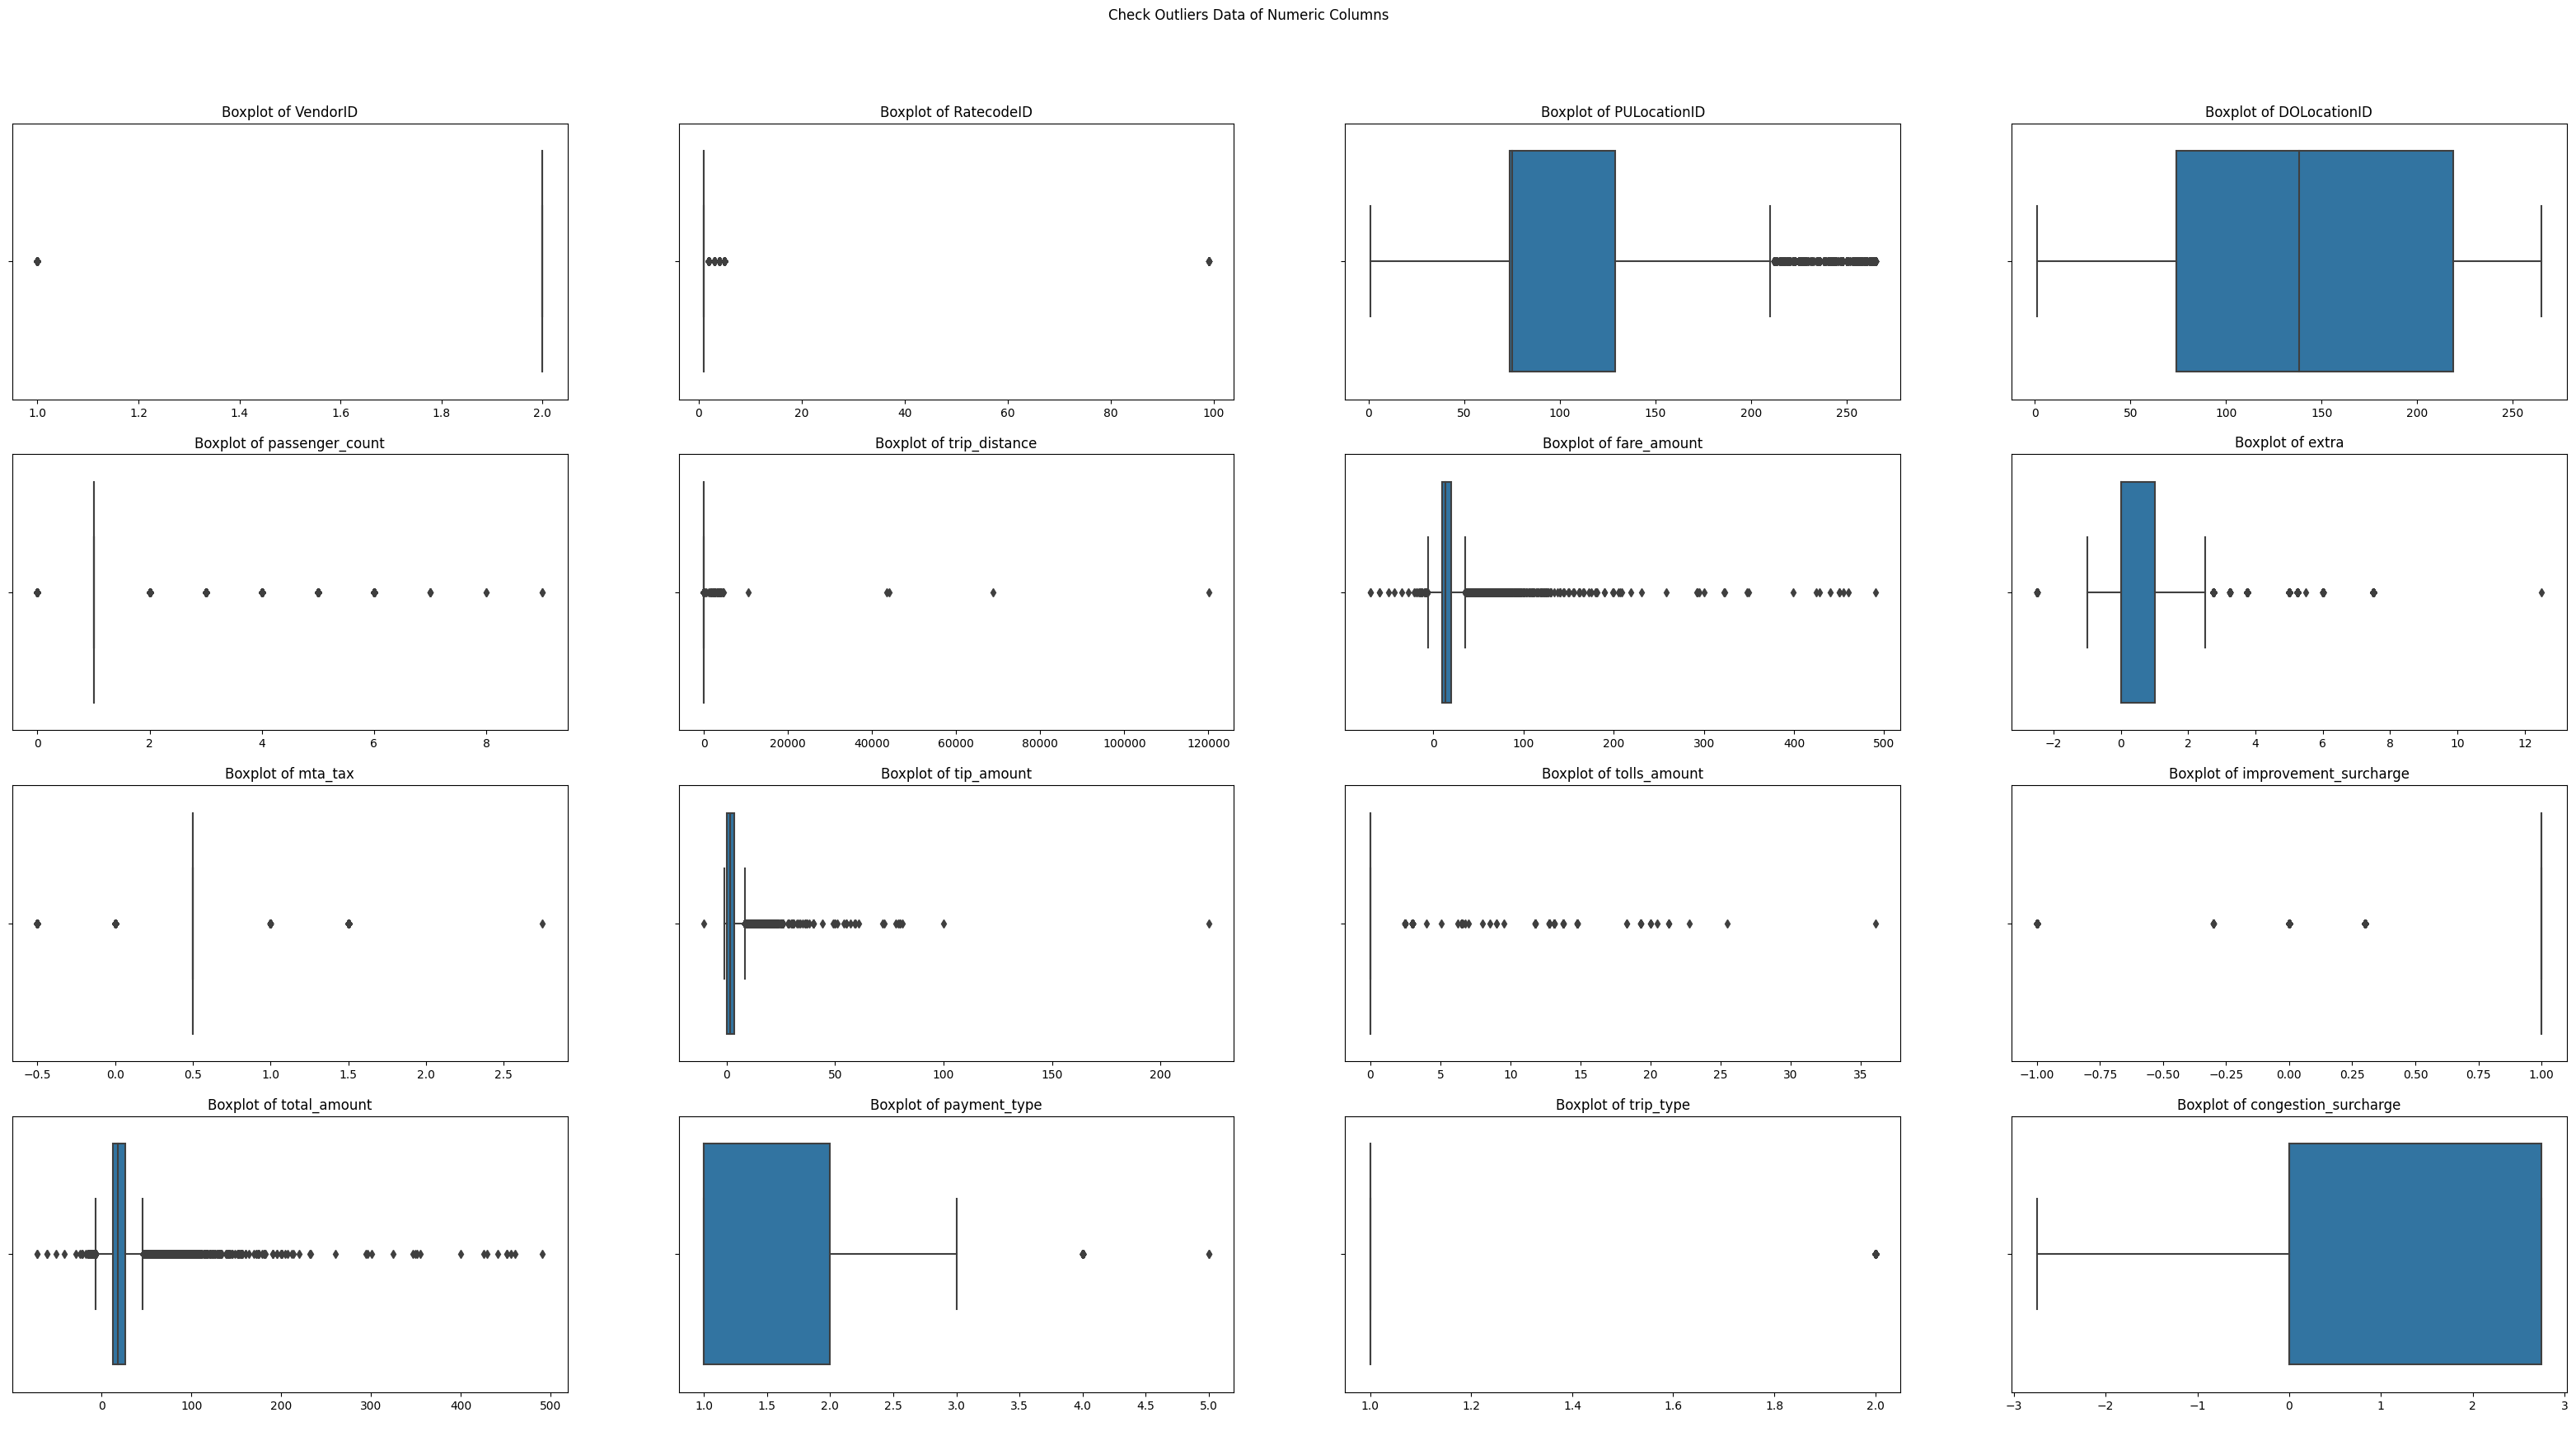

In [7]:
id = 0
n_rows = 4
n_cols = 4
plt.figure(figsize=(40,20))

for i in range(n_rows) :
    for j in range(n_cols):
        
        plt.subplot(n_rows, n_cols, id+1)
        sns.boxplot(data=df3, x=list_column[id])
        plt.xlabel(' ')
        plt.title(f'Boxplot of {list_column[id]}')
        id += 1

plt.suptitle("Check Outliers Data of Numeric Columns", y=0.95)
plt.show()

#### Secara keseluruhan, kesemua data terdapat *outlier* yang mengindikasikan bahwa data terdistribusi tidak normal. Untuk memastikan distribusi data, dilakukan uji normalitas.

## <font color='brown'>Check Normalitas</font>

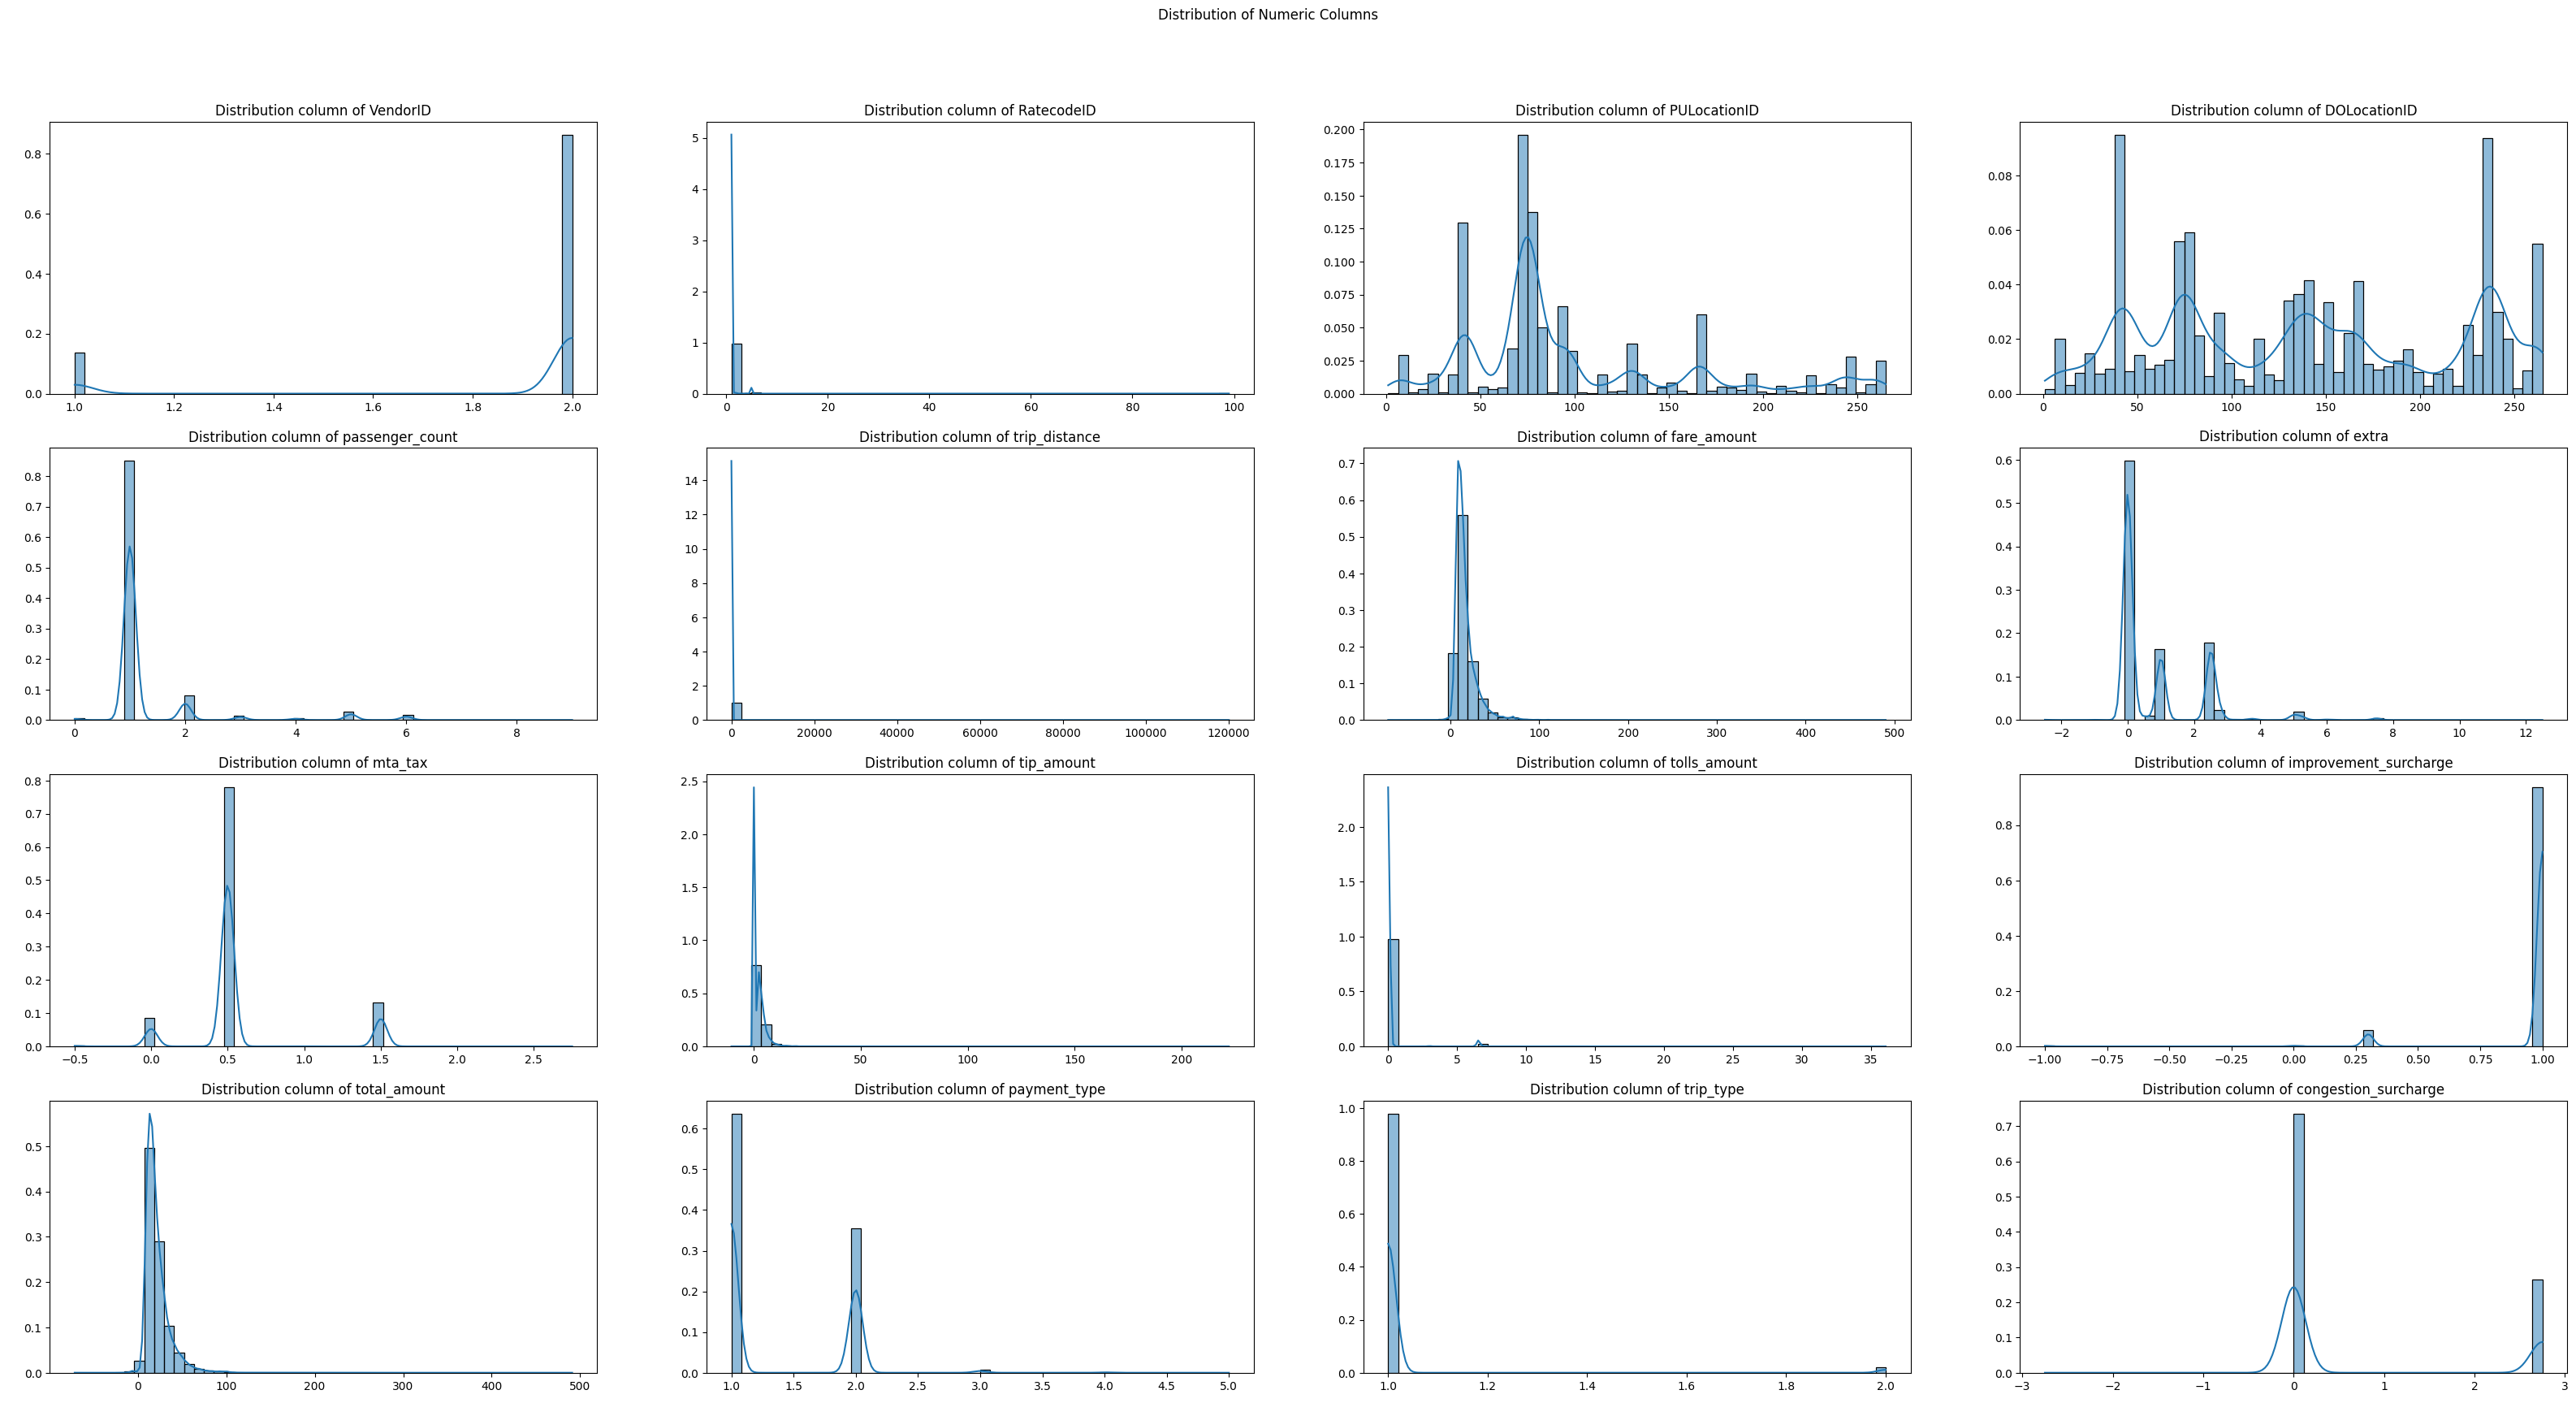

In [8]:
id = 0
n_rows = 4
n_cols = 4
plt.figure(figsize=(40,20))

for i in range(n_rows) :
    for j in range(n_cols):
        
        plt.subplot(n_rows, n_cols, id+1)
        sns.histplot(data = df3, x=list_column[id], stat = "probability", kde=True, bins=50)
        plt.xlabel(' ')
        plt.ylabel(' ')
        plt.title(f'Distribution column of {list_column[id]}')
        id += 1

plt.suptitle("Distribution of Numeric Columns", y=0.95)
plt.show()

In [9]:
for col in numeric_columns:
    stat, pvalue = normaltest(df3[col])
    if pvalue > 0.05 :
        print(f'pvalue {col} = {pvalue:.5f}, kita mengasumsikan data terdistribusi normal')
    else :
        print(f'pvalue {col} = {pvalue:.5f}, kita mengasumsikan data TIDAK terdistribusi normal')

pvalue VendorID = 0.00000, kita mengasumsikan data TIDAK terdistribusi normal
pvalue RatecodeID = nan, kita mengasumsikan data TIDAK terdistribusi normal
pvalue PULocationID = 0.00000, kita mengasumsikan data TIDAK terdistribusi normal
pvalue DOLocationID = 0.00000, kita mengasumsikan data TIDAK terdistribusi normal
pvalue passenger_count = nan, kita mengasumsikan data TIDAK terdistribusi normal
pvalue trip_distance = 0.00000, kita mengasumsikan data TIDAK terdistribusi normal
pvalue fare_amount = 0.00000, kita mengasumsikan data TIDAK terdistribusi normal
pvalue extra = 0.00000, kita mengasumsikan data TIDAK terdistribusi normal
pvalue mta_tax = 0.00000, kita mengasumsikan data TIDAK terdistribusi normal
pvalue tip_amount = 0.00000, kita mengasumsikan data TIDAK terdistribusi normal
pvalue tolls_amount = 0.00000, kita mengasumsikan data TIDAK terdistribusi normal
pvalue ehail_fee = nan, kita mengasumsikan data TIDAK terdistribusi normal
pvalue improvement_surcharge = 0.00000, kita men

#### Hasil memperlihatkan semua data pada kolom *numeric* ter-distribusi *TIDAK NORMAL*

## <font color='brown'>Check Data DateTime</font>

In [10]:
# ubah tipe data 'lpep_pickup_datetime' & 'lpep_dropoff_datetime' ke datetime
df3['lpep_pickup_datetime'] = pd.to_datetime(df3['lpep_pickup_datetime'])
df3['lpep_dropoff_datetime'] = pd.to_datetime(df3['lpep_dropoff_datetime'])

# extract dan create kolom 'day' dan 'hour' dari 'lpep_pickup_datetime' & 'lpep_dropoff_datetime'
df3['pickup_day'] = df3['lpep_pickup_datetime'].dt.day_name()
df3['dropoff_day'] = df3['lpep_dropoff_datetime'].dt.day_name()

# extract dan create kolom 'hour' dari 'lpep_pickup_datetime' & 'lpep_dropoff_datetime'
df3['pickup_hour'] = df3['lpep_pickup_datetime'].dt.hour
df3['dropoff_hour'] = df3['lpep_dropoff_datetime'].dt.hour

# meng-ekstrak nama bulan dari data lpep
df3['pickup_month'] = df3['lpep_pickup_datetime'].dt.strftime('%B')
df3['dropoff_month'] = df3['lpep_dropoff_datetime'].dt.strftime('%B')

In [11]:
# create 'trip_duration' dalam menit
df3['trip_duration'] = round((df3['lpep_dropoff_datetime'] - df3['lpep_pickup_datetime']).dt.total_seconds()/60, 2)

In [12]:
display(df3['pickup_month'].value_counts(), df3['dropoff_month'].value_counts())

pickup_month
January     68208
December        2
February        1
Name: count, dtype: int64

dropoff_month
January     68193
February       16
December        2
Name: count, dtype: int64

**Keterangan:**
- Terlihat bahwa data bulan untuk February, dan December sangat sedikit. Untuk itu pilihannya, dihapus saja.

In [13]:
# buat index data anomali untuk pickup_month dan dropoff_month
anomaliMonthindex = df3[(df3['pickup_month'] == 'February') | (df3['pickup_month'] == 'December') | (df3['dropoff_month'] == 'December') |(df3['dropoff_month'] == 'February')].index.tolist()

# hapus data anomali month
df3.drop(anomaliMonthindex, inplace=True)
df3.reset_index(drop=True, inplace=True)

# check unique values kolom pickuk_month dan dropoff_month
pickupMonth = df3['pickup_month'].unique().tolist()
dropoffMonth = df3['dropoff_month'].unique().tolist()

print(f'Unique values pickup month : {pickupMonth}')
print(f'Unique values dropoff month : {pickupMonth}')

Unique values pickup month : ['January']
Unique values dropoff month : ['January']


## <font color='brown'>Check Tipe Data</font>

In [14]:
# Mengatur opsi untuk menampilkan seluruh isi kolom
pd.set_option('display.max_colwidth', 1)

# Membuat list kosong untuk menyimpan informasi unik tiap kolom
listItem = []

# Mengiterasi tiap kolom dalam DataFrame
for col in df.columns:
    # Menambahkan informasi kolom, tipe data, jumlah unik, nilai unik, dan persentase missing values ke dalam list
    listItem.append([col, df3[col].dtypes, df3[col].nunique(), df3[col].unique()])

# Membuat DataFrame dari list yang telah dibuat
tabelUnique = pd.DataFrame(columns=['Column Name', 'Data Types', 'Number of Unique', 'Unique Sample'],
                          data=listItem)

# Menampilkan DataFrame
tabelUnique

,Column Name,Data Types,Number of Unique,Unique Sample
0,VendorID,int64,2,"[2, 1]"
1,lpep_pickup_datetime,datetime64[ns],66557,"[2023-01-01 00:26:10, 2023-01-02 18:56:58, 2023-01-03 15:28:11, 2023-01-03 17:37:14, 2023-01-03 19:03:53, 2023-01-04 12:45:31, 2023-01-04 14:13:17, 2023-01-04 18:04:19, 2023-01-05 09:54:28, 2023-01-05 15:28:27, 2023-01-05 15:48:46, 2023-01-05 16:24:18, 2023-01-05 16:46:20, 2023-01-05 17:19:59, 2023-01-06 07:09:42, 2023-01-07 11:18:10, 2023-01-07 13:06:51, 2023-01-08 17:17:30, 2023-01-09 09:00:22, 2023-01-10 11:27:14, 2023-01-10 16:25:11, 2023-01-11 09:19:40, 2023-01-11 15:44:10, 2023-01-12 08:39:24, 2023-01-12 09:56:32, 2023-01-12 10:31:00, 2023-01-12 13:15:20, 2023-01-12 13:11:38, 2023-01-12 14:16:10, 2023-01-12 15:39:11, 2023-01-12 21:48:23, 2023-01-13 15:40:23, 2023-01-13 16:16:33, 2023-01-14 11:47:49, 2023-01-14 19:47:23, 2023-01-15 16:36:14, 2023-01-16 14:41:38, 2023-01-17 12:51:23, 2023-01-17 15:27:52, 2023-01-17 15:10:57, 2023-01-18 11:12:18, 2023-01-18 15:20:03, 2023-01-18 16:33:36, 2023-01-18 17:38:11, 2023-01-18 18:36:10, 2023-01-19 11:39:11, 2023-01-19 13:27:18, 2023-01-19 13:13:38, 2023-01-19 15:29:43, 2023-01-19 16:05:22, 2023-01-19 18:27:09, 2023-01-20 09:33:12, 2023-01-20 12:32:19, 2023-01-20 15:50:52, 2023-01-20 17:03:26, 2023-01-20 20:09:32, 2023-01-20 22:49:29, 2023-01-20 23:01:32, 2023-01-23 07:05:46, 2023-01-23 15:18:00, 2023-01-23 16:30:20, 2023-01-23 16:49:01, 2023-01-24 15:44:13, 2023-01-24 16:19:09, 2023-01-24 17:44:48, 2023-01-25 11:17:07, 2023-01-25 13:22:07, 2023-01-25 13:11:35, 2023-01-25 15:49:53, 2023-01-25 18:10:35, 2023-01-25 20:43:23, 2023-01-26 12:15:33, 2023-01-26 15:16:52, 2023-01-26 16:02:09, 2023-01-26 17:43:47, 2023-01-26 19:31:14, 2023-01-26 20:59:03, 2023-01-27 15:25:09, 2023-01-27 16:21:31, 2023-01-30 07:36:35, 2023-01-30 12:07:34, 2023-01-30 16:30:59, 2023-01-30 17:23:01, 2023-01-31 12:22:34, 2023-01-31 14:13:00, 2023-01-05 13:23:00, 2023-01-06 14:39:00, 2023-01-09 19:15:58, 2023-01-20 11:04:00, 2023-01-11 15:30:55, 2023-01-20 09:26:09, 2023-01-03 07:42:05, 2023-01-04 09:26:08, 2023-01-04 12:56:45, 2023-01-05 19:21:53, 2023-01-07 14:23:11, 2023-01-09 15:19:05, 2023-01-13 09:13:52, 2023-01-17 09:05:51, 2023-01-21 17:20:52, ...]"
2,lpep_dropoff_datetime,datetime64[ns],66504,"[2023-01-01 00:37:11, 2023-01-02 19:14:50, 2023-01-03 15:47:47, 2023-01-03 17:51:35, 2023-01-03 19:17:50, 2023-01-04 13:03:24, 2023-01-04 14:28:04, 2023-01-04 18:21:45, 2023-01-05 10:02:13, 2023-01-05 15:48:33, 2023-01-05 16:03:51, 2023-01-05 16:38:12, 2023-01-05 17:00:50, 2023-01-05 17:37:15, 2023-01-06 07:24:36, 2023-01-07 11:29:02, 2023-01-07 13:18:54, 2023-01-08 17:28:50, 2023-01-09 09:14:02, 2023-01-10 11:41:02, 2023-01-10 16:44:01, 2023-01-11 09:32:21, 2023-01-11 16:00:23, 2023-01-12 08:54:26, 2023-01-12 10:10:40, 2023-01-12 10:42:18, 2023-01-12 13:29:51, 2023-01-12 13:30:40, 2023-01-12 14:33:43, 2023-01-12 15:58:06, 2023-01-12 21:59:36, 2023-01-13 16:02:35, 2023-01-13 16:37:45, 2023-01-14 12:06:22, 2023-01-14 19:59:10, 2023-01-15 16:56:31, 2023-01-16 14:52:43, 2023-01-17 13:08:19, 2023-01-17 15:45:51, 2023-01-17 15:29:19, 2023-01-18 11:23:00, 2023-01-18 15:32:17, 2023-01-18 16:51:45, 2023-01-18 17:55:23, 2023-01-18 18:51:25, 2023-01-19 11:56:57, 2023-01-19 13:45:03, 2023-01-19 13:24:58, 2023-01-19 15:45:10, 2023-01-19 16:22:13, 2023-01-19 18:39:57, 2023-01-20 09:49:58, 2023-01-20 12:42:34, 2023-01-20 16:06:21, 2023-01-20 17:21:25, 2023-01-20 20:20:20, 2023-01-20 23:01:01, 2023-01-20 23:19:05, 2023-01-23 07:21:36, 2023-01-23 15:37:19, 2023-01-23 16:45:50, 2023-01-23 17:08:40, 2023-01-24 16:02:22, 2023-01-24 16:41:56, 2023-01-24 18:02:00, 2023-01-25 11:31:15, 2023-01-25 13:42:37, 2023-01-25 13:28:40, 2023-01-25 16:06:36, 2023-01-25 18:28:08, 2023-01-25 20:54:51, 2023-01-26 12:27:09, 2023-01-26 15:37:03, 2023-01-26 16:15:55, 2023-01-26 17:57:37, 2023-01-26 19:46:26, 2023-01-26 21:11:22, 2023-01-27 15:39:56, 2023-01-27 16:33:20, 2023-01-30 07:48:56, 2023-01-30 12:25:38, 2023-01-30 16:46:

#### Keseluruhan kolom ada 20 dengan tipe data yang berbeda-beda. Terdapat anomali - anomali data terlebih pada kolom numerik. Yang memiliki data negatif. Tahapan selanjutnya dengan merubah nilai data negatif pada kolom numeric dengan nilai absolute positif data tersebut

In [15]:
# kolom yang memiliki nilai negatif

negative = []

for col in list_column:
    if (df3[col] < 0).any():
        negative_values = df3[df3[col] < 0][col]
        negative.append(negative_values)

tabelNegativeValues = pd.DataFrame(negative).T.reset_index()
tabelNegativeValues.drop(columns='index', inplace=True)
tabelNegativeValues

,fare_amount,extra,mta_tax,tip_amount,improvement_surcharge,total_amount,congestion_surcharge
0,-3.70,NaN,-0.5,NaN,-1.0,-5.20,NaN
1,-3.00,NaN,-0.5,NaN,-1.0,-4.50,NaN
2,-3.00,NaN,-0.5,NaN,-1.0,-4.50,NaN
3,-35.01,NaN,NaN,NaN,NaN,-29.15,NaN
4,-4.00,NaN,-0.5,NaN,-0.3,-4.80,NaN
...,...,...,...,...,...,...,...
174,-3.00,NaN,-0.5,NaN,-1.0,-4.50,NaN
175,-3.00,NaN,-0.5,NaN,-1.0,-4.50,NaN
176,NaN,NaN,-0.5,NaN,-1.0,-1.50,NaN
177,NaN,NaN,-0.5,NaN,-1.0,-1.50,NaN


In [16]:
# Merubah data yang bernilai negatif menjadi positif

for col in df3.select_dtypes(include=['int', 'float']).columns:
    if (df3[col] < 0).any():
        df3[col] = abs(df3[col])

#### Terdapat anomali data pada kolom numeric yakni pada kolom tersebut terdapat nilai **NOL**. Untuk itu perlu dipisahkan data numeric yang bernilai **NOL** dengan benar.

In [17]:
# Check nama kolom yang data-nya terdapat nilai NOL

zero_columns = []

for col in df3.columns:
    if (df3[col] == 0).any():
        zero_columns.append(col)

zero_columns

['passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'pickup_hour',
 'dropoff_hour',
 'trip_duration']

In [18]:
df3.isnull().sum()

VendorID                 0    
lpep_pickup_datetime     0    
lpep_dropoff_datetime    0    
store_and_fwd_flag       4322 
RatecodeID               4322 
PULocationID             0    
DOLocationID             0    
passenger_count          4322 
trip_distance            0    
fare_amount              0    
extra                    0    
mta_tax                  0    
tip_amount               0    
tolls_amount             0    
ehail_fee                68193
improvement_surcharge    0    
total_amount             0    
payment_type             4322 
trip_type                4332 
congestion_surcharge     4322 
PUBorough                0    
PUZone                   66   
PUservice_zone           201  
DOBorough                0    
DOZone                   242  
DOservice_zone           668  
pickup_day               0    
dropoff_day              0    
pickup_hour              0    
dropoff_hour             0    
pickup_month             0    
dropoff_month            0    
trip_dur

## **Penyelesaian:**
- kolom yang boleh ada nilai *zero* : ***extra*, *tip_amount*, *tolls_amount*, *congestion_surcharge***
- kolom yang tidak boleh ada nilai *zero* : ***passenger_count*, *trip_distance*, *fare_amount*, *mta_tax*, *total_amount* ,*improvement_surcharge***
- kolom yang tidak boleh ada nilai ***zero*** akan ditandai dengan NaN jika terdapat nilai ***zero***

In [19]:
# kolom yang tidak boleh berisi nilai NOL
# nilai NOL akan diganti dengan np.nan

NotBeZero = ['passenger_count', 'trip_distance', 'trip_duration', 'fare_amount', 'mta_tax', 'total_amount' , 'improvement_surcharge']

for col in NotBeZero:
    df3[col] = df3[col].replace(0, np.nan)

## <font color='brown'>Handling Missing Values</font>

## Rules:
- kolom yang memiliki *missing values* lebih dari 3 persen akan di-inputkan nilai pengganti sesuai dengan distribusi data dan tipe data-nya.
- kolom *ehail_fee* akan dihapus krn seluruh data kosong 

In [20]:
# Check Kolom Missing Values
def missing_values():

    # Mengatur opsi untuk menampilkan seluruh isi kolom
    pd.set_option('display.max_colwidth', 1)

    # Membuat list kosong untuk menyimpan informasi unik tiap kolom
    listItem = []

    # Mengiterasi tiap kolom dalam DataFrame
    for col in df3.columns:
        # Memeriksa apakah ada nilai null dalam kolom
        if df3[col].isnull().any():
            # Menghitung persentase missing values dengan penanganan khusus jika jumlah count non-null adalah nol
            if df3[col].count() == 0:
                missing_percentage = np.nan
            else:
                missing_percentage = round((df3[col].isnull().sum() / len(df3)) * 100, 2)
        
            # Menambahkan informasi kolom, tipe data, jumlah unik, nilai unik, dan persentase missing values ke dalam list
            listItem.append([col, df3[col].dtypes, df3[col].nunique(), df3[col].unique(), missing_percentage])

    # Membuat DataFrame dari list yang telah dibuat
    tabelMissingValues = pd.DataFrame(columns=['Column Name', 'Data Types', 'Number of Unique', 'Unique Sample', 'Missing Percentage'],
                          data=listItem)

    # Menampilkan DataFrame
    return tabelMissingValues

In [21]:
missing_values()

,Column Name,Data Types,Number of Unique,Unique Sample,Missing Percentage
0,store_and_fwd_flag,object,2,"[N, Y, nan]",6.34
1,RatecodeID,float64,6,"[1.0, 5.0, nan, 2.0, 3.0, 4.0, 99.0]",6.34
2,passenger_count,float64,9,"[1.0, 2.0, 3.0, 6.0, nan, 4.0, 5.0, 8.0, 9.0, 7.0]",6.83
3,trip_distance,float64,1869,"[2.58, 3.16, 2.55, 1.96, 2.1, 3.3, 3.2, 2.72, 2.65, 2.0, 2.46, 2.28, 2.57, 3.39, 2.15, 2.25, 3.01, 2.06, 3.55, 2.53, 2.49, 3.96, 2.56, 2.77, 2.7, 2.8, 2.04, 2.74, 2.9, 3.11, 3.12, 2.3, 2.43, 2.99, 2.52, 2.38, 2.11, 2.95, 2.73, 2.6, 3.05, 2.97, 2.17, 2.76, 1.94, 3.48, 3.03, 2.69, 3.95, 2.36, 3.76, 3.08, 2.94, 2.82, 2.86, 3.07, 3.32, 2.62, 2.23, 3.45, 2.16, 2.31, 2.61, 2.92, 4.42, 2.2, 2.85, 2.19, 2.83, 2.51, 1.98, 2.08, 3.17, 3.23, 3.73, 3.64, 3.43, 4.09, 3.33, 3.22, 2.5, 3.25, nan, 3.6, 2.78, 6.84, 8.32, 3.19, 2.68, 2.88, 2.4, 2.48, 2.59, 3.87, 3.0, 2.93, 3.15, 3.4, 2.45, 3.27, ...]",4.91
4,fare_amount,float64,2526,"[14.9, 19.8, 19.1, 15.6, 13.5, 13.0, 18.4, 11.4, 16.3, 17.7, 14.2, 21.2, 20.5, 12.1, 17.0, 12.8, 15.5, 10.5, 13.84, 18.72, 16.32, 22.6, 24.7, 26.8, 21.9, 11.0, 20.8, 14.0, 18.98, 16.4, 36.6, 41.7, 14.5, 26.1, 29.6, 15.0, 24.0, 23.3, 20.04, 27.85, 16.57, 20.34, 25.4, 28.92, 53.4, 61.1, 35.2, 28.38, 33.8, 28.2, 32.4, 28.9, 31.0, 27.5, 31.7, 19.0, 23.17, 28.24, 24.21, 18.06, 38.7, 25.8, 34.75, 37.96, 41.52, 29.76, 28.56, 25.44, 23.5, 31.2, 26.0, 26.5, 11.5, 18.0, 9.5, 10.7, 41.5, 21.53, 16.28, 20.55, 16.05, 18.83, 15.15, 13.52, 17.19, 14.74, 17.09, 13.11, 14.98, 34.5, 34.0, 23.66, 26.45, 9.0, 17.91, 14.52, 16.25, 17.62, 57.6, 16.0, ...]",0.12
5,mta_tax,float64,4,"[0.5, 1.5, nan, 1.0, 2.75]",8.47
6,ehail_fee,float64,0,[nan],NaN
7,improvement_surcharge,float64,2,"[1.0, 0.3, nan]",0.27
8,total_amount,float64,4615,"[24.18, 24.05, 28.02, 22.35, 20.25, 17.25, 29.34, 15.65, 28.86, 22.85, 24.35, 21.65, 26.45, 21.95, 22.14, 20.45, 19.85, 23.06, 33.54, 22.98, 26.34, 25.75, 20.4, 20.55, 21.25, 27.44, 24.65, 18.05, 23.81, 25.15, 20.71, 29.7, 20.46, 30.06, 27.18, 21.3, 33.61, 28.15, 28.5, 24.25, 19.15, 23.82, 28.92, 22.45, 26.79, 23.65, 25.35, 26.85, 23.75, 31.86, 26.65, 29.95, 27.03, 25.5, 34.75, 26.56, 25.24, 30.18, 23.34, 24.45, 25.98, 24.15, 22.1, 23.05, 17.7, 25.51, 25.17, 30.56, 24.08, 18.55, 34.91, 36.17, 28.63, 33.35, 26.15, 28.05, 15.75, 26.05, 29.22, 26.94, 29.46, 19.5, 22.73, 25.19, 43.95, 52.27, 27.11, 24.6, 31.38, 24.77, 25.06, 18.35, 18.45, 26.82, 39.42, 25.31, 24.94, 37.85, 22.26, 26.19, ...]",0.10
9,payment_type,float64,5,"[1.0, 2.0, nan, 3.0, 4.0, 5.0]",6.34


In [22]:
# menghapus kolom ehail_fee

df3.drop(columns='ehail_fee', inplace=True)

### **PULocationID and DOLocationID**

- *Pickup/drop-off Location ID* harus berada di rentang [1,263]

In [24]:
# Mengambil index PULocationID dan DOLocationID yang tidak di rentang [1,263]
anomaliLocationID = df3[(df3['PULocationID'] < 1) | (df3['PULocationID'] > 263) | (df3['DOLocationID'] < 1) | (df3['DOLocationID'] > 263)].index

# Menghapus data dimana PULocationID dan DOLocationID tidak di rentang [1,263]
df3.drop(anomaliLocationID, inplace=True)
df3.reset_index(drop=True, inplace=True)

# check missing values
check1 = df3['PULocationID'].isnull().any()
check2 = df3['DOLocationID'].isnull().any()

print(f'Missing values kolom PULocationID: {check1}')
print(f'Missing values kolom DOLocationID: {check2}')

Missing values kolom PULocationID: False
Missing values kolom DOLocationID: False


In [25]:
# Check kolom missing values lainnya
missing_values()['Column Name'].unique()

array(['store_and_fwd_flag', 'RatecodeID', 'passenger_count',
       'trip_distance', 'fare_amount', 'mta_tax', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type',
       'congestion_surcharge', 'trip_duration'], dtype=object)

### ***store_and_fwd_flag***

- Pada trip record <u>menunjukkan apakah rekaman perjalanan tersebut disimpan dalam memori kendaraan sebelum dikirim ke vendor.</u> **Hal ini terjadi ketika kendaraan tidak memiliki koneksi ke server untuk langsung mengirim data perjalanan.** 
- Dalam situasi ini, data perjalanan akan disimpan dalam memori kendaraan dan dikirim ke vendor saat koneksi tersedia. 
- Flag "store and forward" memberikan informasi tentang apakah rekaman perjalanan tersebut mengalami penundaan dalam pengiriman data karena kendaraan tidak memiliki koneksi langsung ke server saat itu.
- Option:
    - Y : ***rekamanam perjalanan mengalami penundaan dalam pengiriman data (karena kendaraan tidak memiliki koneksi langsung ke server saat itu)***
    - N : ***rekaman perjalanan tidak mengalami penundaan dalam pengiriman data***

In [26]:
SumOptionN = len(df3[df3['store_and_fwd_flag'] == 'N'])
SumOptionY = len(df3[df3['store_and_fwd_flag'] == 'Y'])
MissingValues = len(df3[df3['store_and_fwd_flag'].isnull()])

print(f'Jumlah rekaman perjalanan yang TIDAK mengalami penundaan sebesar {SumOptionN}')
print(f'Jumlah rekaman perjalanan yang MENGALAMI penundaan sebesar {SumOptionY}')
print(f'Jumlah missing values pada rekaman perjalanan sebesar {MissingValues}')

Jumlah rekaman perjalanan yang TIDAK mengalami penundaan sebesar 62897
Jumlah rekaman perjalanan yang MENGALAMI penundaan sebesar 282
Jumlah missing values pada rekaman perjalanan sebesar 4302


#### *missing values* pada kolom *store_and_fwd_flag* mencapai <u>4324 data</u>. Terlihat juga bahwa, data dengan index *missing values* kolom *store_and_fwd_flag* memiliki lebih dari 1 kolom *missing_values*. Sehingga diputuskan untuk *missing values* kolom *store_and_fwd_flag* diganti dengan nilai **'Y'** yang artinya data *missing values* kolom *store_and_fwd_flag* dianggap rekaman data mengalami penundaan yang menyebabkan data mengandung *missing values*

In [29]:
# mengganti missing values pada kolom store_and_fwd_flag dengan nilai 'Y'
df3['store_and_fwd_flag'].fillna('Y', inplace=True)

# check missing values
check = df3['store_and_fwd_flag'].isnull().any()

print(f'Missing values kolom store_and_fwd_flag: {check}')

Missing values kolom store_and_fwd_flag: False


In [30]:
# Check kolom missing values lainnya
missing_values()['Column Name'].unique()

array(['RatecodeID', 'passenger_count', 'trip_distance', 'fare_amount',
       'mta_tax', 'improvement_surcharge', 'total_amount', 'payment_type',
       'trip_type', 'congestion_surcharge', 'trip_duration'], dtype=object)

### ***RateCodeID***

- RateCodeID mengindikasikan kode tarif terakhir yang diterapkan pada saat perjalanan taksi berakhir. 
- Dalam konteks ini RateCodeID terakhir ini menggambarkan jenis tarif yang digunakan pada akhir perjalanan, yang dapat mempengaruhi biaya akhir yang dibebankan kepada penumpang.
- Memiliki Kriteria: 
    - 1= Standard rate
        - Mengindikasikan penggunaan tarif standar yang berlaku umum untuk perjalanan taksi di New York City.
    - 2=JFK
        - Menunjukkan penggunaan tarif khusus yang berlaku untuk perjalanan menuju atau dari **Bandara Internasional John F. Kennedy (JFK).**
    - 3=Newark
        - Menunjukkan penggunaan tarif khusus yang berlaku untuk perjalanan menuju atau dari **Bandara Internasional Newark Liberty (Newark).**
    - 4=Nassau or Westchester
        - Menunjukkan penggunaan tarif khusus yang berlaku untuk perjalanan menuju atau dari wilayah Nassau County atau Westchester County di sekitar New York City.
    - 5=Negotiated fare
        - Mengindikasikan penggunaan tarif yang ditetapkan melalui negosiasi antara pengemudi dan penumpang, bukan tarif standar yang ditentukan.
    - 6=Group ride
        - Menunjukkan bahwa perjalanan merupakan perjalanan kelompok, di mana beberapa penumpang yang tidak saling kenal berbagi taksi untuk pergi ke tujuan yang berdekatan.

**Treatment**
- MissingValues : di isikan dengan *modus*. Karena, data RatecodeID merupakan data *category*
- RatecodeID = 99 : dihapus

In [31]:
# Check data kolom RatecodeID
check = df3['RatecodeID'].isnull().any()
display(df3['RatecodeID'].value_counts(), f'Apakah masih ada missing values di kolom RatecodeID: {check}')

RatecodeID
1.0     61717
5.0     1271 
2.0     155  
3.0     24   
99.0    9    
4.0     3    
Name: count, dtype: int64

'Apakah masih ada missing values di kolom RatecodeID: True'

In [32]:
# mencari index data ratecode 99
index99 = df3[df3['RatecodeID'] == 99].index

# Menghapus baris pada kolom RatecodeID yang bernilai 99
df3.drop(index99, axis=0, inplace=True)
df3.reset_index(drop=True, inplace=True)

# mengganti missing values di RatecodeID dengan nilai modus-nya
df3['RatecodeID'].fillna(df3['RatecodeID'].mode()[0], inplace=True)

# Check kembai apakah masih terdapat missing values
check = df3['RatecodeID'].isnull().any()
print(f'\nApakah masih ada mising values di kolom RatecodeID: {check}')


Apakah masih ada mising values di kolom RatecodeID: False


In [33]:
# Merubah nilai data menjadi kategori
df3.loc[df3['RatecodeID'] == 1.0,'RatecodeID'] = 'Standard rate'
df3.loc[df3['RatecodeID'] == 2.0,'RatecodeID'] = 'JFK'
df3.loc[df3['RatecodeID'] == 3.0,'RatecodeID'] = 'Newark'
df3.loc[df3['RatecodeID'] == 4.0,'RatecodeID'] = 'Nassau or Westchester'
df3.loc[df3['RatecodeID'] == 5.0,'RatecodeID'] = 'Negotiated fare'
df3.loc[df3['RatecodeID'] == 6.0,'RatecodeID'] = 'Group ride'

### **payment_type**

Payment_type = Kode numerik yang menandakan cara penumpang membayar perjalanan
- 1 = Credit card
- 2 = Cash
- 3 = Tidak kembali
- 4 = Ada konfilik
- 5 = Unknown
- 6 = Perjalanan yang dibatalkan

In [34]:
# mengganti missing values dengan nilai modus
df3['payment_type'].fillna('Unknown', inplace=True)

# Check kembai apakah masih terdapat missing values
check = df3['payment_type'].isnull().any()
print(f'\nApakah terdapat mising values di kolom payment type: {check}')


Apakah terdapat mising values di kolom payment type: False


In [35]:
# mengganti nilai payment_type dengan kategori
df3.loc[df3['payment_type'] == 1, 'payment_type'] = 'Credit Card'
df3.loc[df3['payment_type'] == 2, 'payment_type'] = 'Cash'
df3.loc[df3['payment_type'] == 3, 'payment_type'] = 'No Charge'
df3.loc[df3['payment_type'] == 4, 'payment_type'] = 'Dispute'
df3.loc[df3['payment_type'] == 5, 'payment_type'] = 'Unknown'
df3.loc[df3['payment_type'] == 6, 'payment_type'] = 'Voided Trip'

### **passenger_count**
- maksimal *penumpang* sebesar 6 orang menurut *https://id.ticotourandtravel.com/3931-everything-you-need-to-know-about-new-york-city-taxis*


In [36]:
# Check unique data kolom passenger_count
df3['passenger_count'].value_counts()

passenger_count
1.0    53682
2.0    5045 
5.0    1763 
6.0    1050 
3.0    942  
4.0    360  
7.0    3    
8.0    2    
9.0    1    
Name: count, dtype: int64

In [37]:
# Hapus data passenger_count yang mempunyai data lebih dari 6 orang
passengerAnomali = df3[(df3['passenger_count'] > 6)].index.to_list()

# Hapus data
df3.drop(passengerAnomali, inplace=True)
df3.reset_index(drop=True, inplace=True)

# Check kembai unique values 
unique = df3['passenger_count'].unique()
print(f'\nUnique values kolom trip type: {unique}')


Unique values kolom trip type: [ 1.  2.  3.  6. nan  4.  5.]


In [38]:
# Input missing values dengan median
df3['passenger_count'].fillna(df3['passenger_count'].median(), inplace=True)

### **trip_distance**
- trip_distance harus lebih dari 0 mil tetapi kurang dari 100 mil.

- Keterangan:
    - Missing values diganti dengan *median*
    - Jika ada data trip distance < 1 dan > 100, maka harus dihapus

In [41]:
# index data trip_distance < 1 dan trip_distance > 100
tripDistanceAnomali = df3[(df3['trip_distance'] < 1) | (df3['trip_distance'] > 100)].index

print(f'Jumlah anomali trip distance: {len(tripDistanceAnomali)}')
print(f'Jumlah total data: {len(df3)}')
print('Keputusan untuk menghapus data trip distance < 1 mil dan > 100 mil')

Jumlah anomali trip distance: 10671
Jumlah total data: 67466
Keputusan untuk menghapus data trip distance < 1 mil dan > 100 mil


In [42]:
# menghapus data anomali
df3.drop(tripDistanceAnomali, inplace=True)
df3.reset_index(drop=True, inplace=True)

print(f'Jumlah data sekarang: {len(df3)}')
print('Data anomali telah dihapus')

Jumlah data sekarang: 56795
Data anomali telah dihapus


In [43]:
# Input missing values
df3['trip_distance'].fillna(df3['trip_distance'].median(), inplace=True)

In [44]:
# check missing values
df3['trip_distance'].isnull().any()

False

### **fare_amount**
- Tarif berdasarkan waktu dan jarak dihitung menggunakan meteran.
- Saat ini, biaya sudah mencakup biaya tambahan untuk *rush hours* dan *nighttime*

- https://rules.cityofnewyork.us/rule/taximeter-rate-of-fare-and-various-surcharges/ :
    - Biaya awal per unit dinaikkan dai $2.50 menjadi $3.00
    - Biaya tambahan per unit dinaikkan dari $0.50 menjadi $0.70
    - Biaya tambahan untuk jam sibuk *rush hours* dinaikkan dari $1.00 menjadi $2.50
    - Biaya tambahan untuk jam malam *nighttime* dinaikkan dari $0.50 menjadi $1.00

#### Berdasarkan kebijakan diatas **fare_amount** setidaknya bernilai $3.7

In [45]:
# index data fare_amount <$3.7
anomaliFareAmount = df3[df3['fare_amount'] < 3.7].index.tolist()

# hapus data anomali
df3.drop(anomaliFareAmount, inplace=True)
df3.reset_index(drop=True, inplace=True)

In [46]:
# Input missing values dengan nilai median
df3['fare_amount'].fillna(df3['fare_amount'].median(), inplace=True)

In [47]:
# check missing values
df3['fare_amount'].isna().any()

False

### **mta_tax**

- $0.50 MTA tax that is automatically triggered based on the metered rate in use.
- https://www.tax.ny.gov/bus/taxi/
    - Tarif MTA tax pada taksi di New York City adalah $0.5 untuk semua perjalanan sebagai berikut:
        - starts and ends in New York City (meaning New York (Manhattan), Kings (Brooklyn), Queens, Richmond (Staten Island), and Bronx counties); or
        - starts in New York City and ends in any of the following counties: Dutchess, Nassau, Orange, Putnam, Rockland, Suffolk, and Westchester.
- Nilai mta_tax keseluruhan akan diganti sebesar $0.5

In [48]:
# mengganti semua nilai mta_tax menjadi 0.5
df3['mta_tax'] = df3['mta_tax'].replace(df3['mta_tax'].unique(), 0.5)

In [49]:
# Check missing values mta_tax
df3['mta_tax'].isnull().any()

False

### **improvement_surcharge**

- Biaya tambahan sebesar $0.30 dikenakan pada perjalanan yang dipesan melalui panggilan. Biaya tambahan ini diberlakukan sejak 2015

- https://rules.cityofnewyork.us/rule/taximeter-rate-of-fare-and-various-surcharges/:
    - Biaya tambahan perbaikan taksi dan biaya tambahan perbaikan *street hail* meningkat dari $0.30 menjadi $1.00

#### Semua nilai improvement surcharge diganti dengan nilai sebesar $1

In [50]:
# Mengganti semua nilai improvement surcharge dengan nilai sebesar $1.0
df3['improvement_surcharge'] = df3['improvement_surcharge'].replace(df3['improvement_surcharge'].unique(), 1)

In [51]:
# Check missing values
df3['improvement_surcharge'].isnull().any()

False

### **trip_type**

- Kode yang menunjukkan apakah perjalanan tersebut merupakan perjalanan di jalanan atau pengiriman.
- Option:
    - 1 = Street-hail
    - 2 = Dispatch

In [52]:
# Check unique data kolom trip_type
df3['trip_type'].value_counts()

trip_type
1.0    51373
2.0    886  
Name: count, dtype: int64

In [53]:
# mengganti nilai trip_type dengan kategori
df3.loc[df3['trip_type'] == 1, 'trip_type'] = 'Street-hail'
df3.loc[df3['trip_type'] == 2, 'trip_type'] = 'Dispatch'

# Check missing values di kolom trip type
jumMissing = df3['trip_type'].isnull().sum()

# Unique values kolom trip type
uniqueTrip = df3['trip_type'].unique()

print(f'Jumlah missing values kolom trip_type {jumMissing}')
print(f'Data unique kolom trip_type {uniqueTrip}')

Jumlah missing values kolom trip_type 3984
Data unique kolom trip_type ['Street-hail' nan 'Dispatch']


In [54]:
# Input missing values 
df3['trip_type'].fillna('Unknown', inplace=True)

In [55]:
# Check missing values
df3['trip_type'].isnull().any()

False

### **congestion_surcharge**

- https://www.nyc.gov/site/tlc/about/congestion-surcharge.page:
    - Pernyataan di atas menjelaskan tentang pemberlakuan Congestion Surcharge di New York State yang berlaku mulai 1 Januari 2019. Congestion Surcharge ini akan dikenakan untuk perjalanan dalam taksi dan For-Hire Vehicles (FHV) yang dimulai, berakhir, atau melewati Congestion Zone. Congestion Zone ini terletak di Manhattan, di bagian selatan jalan 96th Street.
    - Surcharge ini diberlakukan sebagai upaya untuk mengurangi kemacetan lalu lintas di wilayah Manhattan yang padat. Tarif tambahan ini akan ditambahkan ke biaya perjalanan yang ada dan akan menjadi tanggung jawab penumpang. Dengan adanya Congestion Surcharge, diharapkan dapat mendorong penggunaan transportasi yang lebih efisien dan berkelanjutan di area yang padat seperti Manhattan.
    - Besarnya sebagai berikut:
        - $2.50 for non-shared trips in taxicabs
        - $2.75 for non-shared trips in For-Hire-Vehicles, including limousines, and Street-Hail Liveries (Green Taxis)
        - $0.75 for shared-rides in any type of vehicle
        - No surcharge for Access-A-Ride, or any other MTA dispatched trip.
- https://www.nyc.gov/site/tlc/passengers/taxi-fare.page:
    - Untuk perjalanan ke atau dari Westchester dan Nassau Counties:
        - Ditambahkan New York State Congestion Surcharge sebesar $2.50 untuk Yellow Taxi atau $2.75 untuk Green Taxi dan FHV, atau 75 sen untuk perjalanan berbagi, untuk semua perjalanan yang dimulai, berakhir, atau melewati Manhattan di bawah 96th Street.
    - Untuk tujuan di luar Kota:
        - Ditambahkan New York State Congestion Surcharge sebesar $2.50 untuk Yellow Taxi atau $2.75 untuk Green Taxi dan FHV, atau 75 sen untuk perjalanan berbagi, untuk semua perjalanan yang dimulai, berakhir, atau melewati Manhattan di bawah 96th Street.

#### Treatment:
- semua nilai improvement surcharge diganti dengan nilai sebesar $1

- DOBorough selain **Manhattan** tidak dikenakan biaya **Congestion Surcharge**
- Besar biaya:
    - $2.75 untuk **Green Taxi** dan tipe non-shared trips in For-Hire_Vehicles, including limousines, and Street-Hail Liveries. Untuk tujuan ke luar kota Manhattan atau untuk perjalanan ke atau dari Westchester dan Nassau Conties menuju Manhattan
    - $2.50 untuk **Yellow Taxi** dan tipe non-shared trips in taxicabs. Untuk tujuan ke luar kota Manhattan atau untuk perjalanan ke atau dari Westchester dan Nassau Conties menuju Manhattan
    - $0.75 untuk shared-rides untuk semua tipe kendaraan
    - Tidak ada biaya tambahan untuk Access-A-Ride, or any other MTA dispatched trip.

In [56]:
# Check nilai congestion surcharge untuk PUBorough dan DOBorough di Manhattan
checkCongestionsurchargeManhattan = pd.DataFrame(df3[(df3['PUBorough'].isin(['Manhattan'])) & (df3['DOBorough'].isin(['Manhattan']))][['congestion_surcharge']].value_counts())
checkCongestionsurchargeManhattan

,count
congestion_surcharge,
0.00,14624
2.75,13875
2.50,13


In [57]:
# Check nilai congestion surcharge untuk PUBorough dan DOBorough selain di Manhattan
checkCongestionsurchargeNotManhattan = pd.DataFrame(df3[(~df3['PUBorough'].isin(['Manhattan'])) & (~df3['DOBorough'].isin(['Manhattan']))][['congestion_surcharge']].value_counts())
checkCongestionsurchargeNotManhattan

,count
congestion_surcharge,
0.00,19037
2.75,23


In [58]:
YellowTaxi = len(df3[(df3['congestion_surcharge'] == 2.5)])
GreenTaxi = len(df3[(df3['congestion_surcharge'] == 2.75)])
anomali1 = len(df3[df3['congestion_surcharge'] == 1.0])

print(f'Jumlah data Yellow Taxi sebesar {YellowTaxi}')
print(f'Jumlah data Green Taxi sebesar {GreenTaxi}')
print(f'Jumlah data Anomali sebesar {anomali1}')

Jumlah data Yellow Taxi sebesar 16
Jumlah data Green Taxi sebesar 16051
Jumlah data Anomali sebesar 0


#### **Tindakan:**

- Congestion Surcharge Manhattan:
    - Nilai 1.0, memilih untuk dihapus. Disebabkan oleh *in-consistent data*, artinya terdapat 2 kemungkinan yaitu data tersebut bisa berasal dari **Yellow Taxi (diganti dengan $2.5)** ataupun **Green Taxi (diganti dengan 2.75)**
    - Nilai 2.5, diartikan biaya **Congestion Surcharge** untuk **Taksi Yellow**
- Congestion Surcharge Not Manhattan:
    - Nilai 1.0, diganti menjadi 0.00. Disebabkan oleh perjalanan *pick up* (PU) dan *drop off* (DO) tidak melewati Manhattan
    - Nilai 2.75, diganti menjadi 0.00. Disebabkan oleh perjalanan *pick up* (PU) dan *drop off* (DO) tidak melewati Manhattan
- Berdasarkan data terlihat bahwa data **Yellow Taxi (congestion surcharge = 2.5)** tidak sebanding dengan data **Green Taxi (congestion surcharge = $2.75)**. Untuk itu diambil keputusan ***menghapus data congestion surcharge bernilai 2.50***
- Jika terdapat missing values pada data congestion surcharge akan dihapus karena kita tidak dapat memastikan dengan benar besaran congestion surcharge pada data tersebut.

In [59]:
# index data anomali
IndexAnomali = df3[(df3['congestion_surcharge']==1.0) | (df3['congestion_surcharge']==2.5)].index.tolist()

# hapus data anomali
df3.drop(IndexAnomali, inplace=True)
df3.reset_index(drop=True, inplace=True)

In [63]:
# Index missing values congestion surcharge
# untuk selanjutnya akan dihapus data ini
AnomaliCongestionSurcharge = df3[df3['congestion_surcharge'].isna()].index.tolist()

# hapus data anomali
df3.drop(AnomaliCongestionSurcharge, inplace=True)

### ***total_amount***

#### Tindakan

dilakukan kalkulasi ulang dimana nilai **total amount** berasal dari penjumlahan **fare amount**, **extra**, **mta_tax**, **tip_amount**, **tolls_amount**, **improvement_surcharge**, **congestion_surcharge**

In [65]:
# total amount 
df3['total_amount'] = df3['fare_amount'] + df3['extra'] + df3['mta_tax'] + df3['tip_amount'] + df3['tolls_amount'] + df3['improvement_surcharge'] + df3['congestion_surcharge']

### ***trip_duration***

In [68]:
# check data missing values
df3[df3['trip_duration'].isna()]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,DOBorough,DOZone,DOservice_zone,pickup_day,dropoff_day,pickup_hour,dropoff_hour,pickup_month,dropoff_month,trip_duration
4009,1,2023-01-05 07:54:34,2023-01-05 07:54:34,N,Standard rate,42,42,1.0,1.90,12.8,...,Manhattan,Central Harlem North,Boro Zone,Thursday,Thursday,7,7,January,January,NaN
18460,1,2023-01-13 16:57:42,2023-01-13 16:57:42,N,Standard rate,49,49,1.0,2.27,18.5,...,Brooklyn,Clinton Hill,Boro Zone,Friday,Friday,16,16,January,January,NaN
51242,1,2023-01-09 17:00:08,2023-01-09 17:00:08,N,Standard rate,33,33,1.0,2.27,15.2,...,Brooklyn,Brooklyn Heights,Boro Zone,Monday,Monday,17,17,January,January,NaN
51852,1,2023-01-26 12:47:11,2023-01-26 12:47:11,N,Standard rate,55,55,1.0,2.27,41.2,...,Brooklyn,Coney Island,Boro Zone,Thursday,Thursday,12,12,January,January,NaN
56162,1,2023-01-21 17:09:25,2023-01-21 17:09:25,N,Standard rate,21,21,1.0,2.27,15.2,...,Brooklyn,Bensonhurst East,Boro Zone,Saturday,Saturday,17,17,January,January,NaN


diambil keputusan untuk menghapus data missing values pada kolom **trip_duration** dengan alasan waktu pick up dan drop off menunjukkan nilai yang sama persis

In [70]:
# check index missing values
TripDurationAnomali = df3[df3['trip_duration'].isna()].index.tolist()

# hapus data anomali
df3.drop(TripDurationAnomali, inplace=True)

In [72]:
df3.isnull().sum()

VendorID                 0
lpep_pickup_datetime     0
lpep_dropoff_datetime    0
store_and_fwd_flag       0
RatecodeID               0
PULocationID             0
DOLocationID             0
passenger_count          0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
payment_type             0
trip_type                0
congestion_surcharge     0
PUBorough                0
PUZone                   0
PUservice_zone           0
DOBorough                0
DOZone                   0
DOservice_zone           0
pickup_day               0
dropoff_day              0
pickup_hour              0
dropoff_hour             0
pickup_month             0
dropoff_month            0
trip_duration            0
dtype: int64

## <font color='brown'>Check Korelasi Data</font>

In [73]:
df_corr = df3.corr(numeric_only=True)

In [74]:
matriks = np.triu(df_corr)

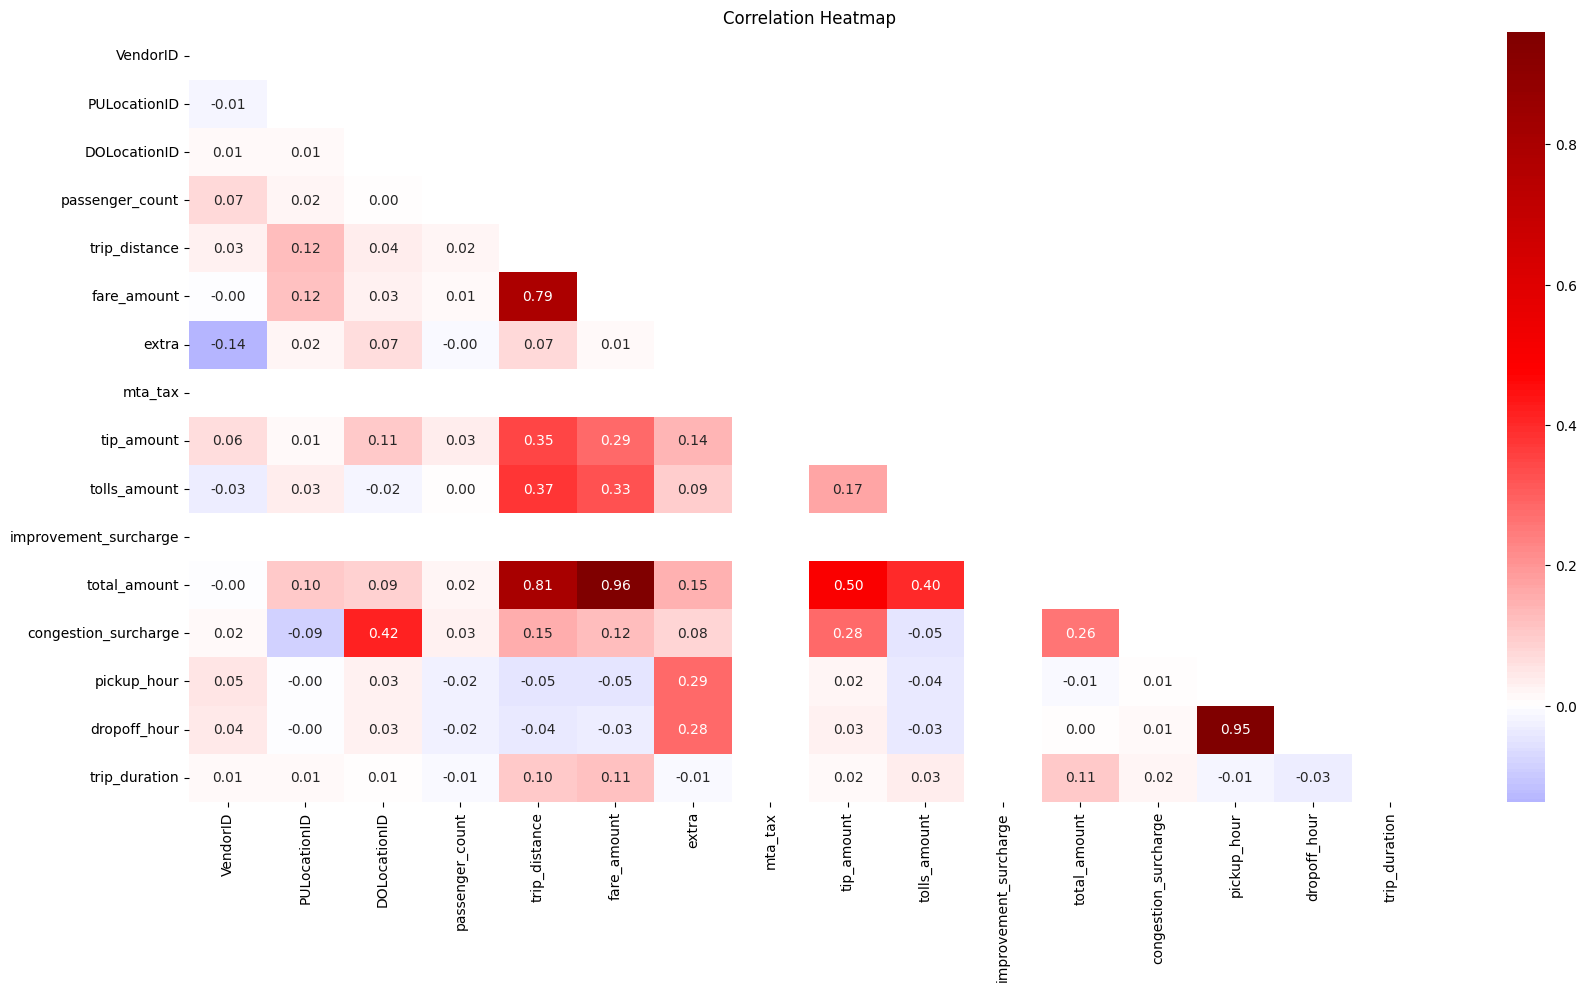

In [75]:
plt.figure(figsize=(20,10))

sns.heatmap(df_corr, annot=True, cmap='seismic', center=0 , mask=matriks, fmt='.2f')

plt.title('Correlation Heatmap')

plt.show()

- **Kesimpulan:**
    - positif moderate - strong correlation:
        - *total_amount* dengan *trip_distance*, *fare_amount*, *trip_duration*, *tip_amount*, *tolls_amount*
            - artinya, semakin besar atau kecilnya nilai **trip_distance, fare_amount, trip_duration, tip_amount, atau tolls_amount**, maka semakin besar atau kecil pula nilai **total amount**.
        - *dropoff_hour* dan *pickup_hour*
            - artinya, waktu perjalanan  **dropoff** akan naik sejalan dengan **pickup**.
        - *fare_amount* dengan *trip_duration*
            - artinya, biaya dasar **fare_amount** akan naik sejalan dengan **trip_duration** perjalanan.

# **Data Analysis**
Analisis akan dilakukan dengan melihat bagaimana tren penumpang berdasarkan pickup, dropoff, metode pembayaran, hari serta pukul berapa yang menjadi pick season. Dari informasi ini kita bisa mengetahui pola-pola penumpang dan preferensi mereka dalam menggunakan layanan transportasi. Dengan menganalisis tren penumpang kita dapat mengidentifikasi pola-pola penumpang yang berpotensi memberikan wawasan berharga. 

## <font color='gold'>Identifikasi tren berdasarkan *pickup* dan *dropoff*</font>

Kita dapat menganalisis data untuk melihat daerah atau lokasi yang paling sering menjadi *pickup* dan *dropoff* bagi penumpang. Hal ini dapat memberikan wawasan tentang pusat aktivitas atau tujuan yang populer bagi penumpang.

In [76]:
# Menambahkan kolom baru
df3['count'] = 1

# Total Jumlah Penumpang yang Pick Up Berdasarkan Borough
PUArea = df3.groupby(['PUBorough', 'PUZone', 'PUservice_zone'])[['count']].sum()
# DOArea.rename(columns={'passenger_count' : 'SUMpassenger_count'}, inplace=True)
PUArea = PUArea.reset_index().sort_values(by = 'count', ascending=False)
# DOArea = DOArea.drop(columns='passenger_count', axis=1)
PUArea['Area'] = 'PickUp'

PUArea.rename(columns={'count': 'jumlah_perjalanan',
                       'PUBorough': 'Borough',
                       'PUZone': 'Zone',
                       'PUservice_zone': 'service_zone'}, inplace=True)

In [77]:
# Total Jumlah Penumpang yang Drop Off Berdasarkan Borough

DOArea = df3.groupby(['DOBorough', 'DOZone', 'DOservice_zone'])[['count']].sum()
# DOArea.rename(columns={'passenger_count' : 'SUMpassenger_count'}, inplace=True)
DOArea = DOArea.reset_index().sort_values(by = 'count', ascending=False)
# DOArea = DOArea.drop(columns='passenger_count', axis=1)
DOArea['Area'] = 'DropOff'

DOArea.rename(columns={'count': 'jumlah_perjalanan',
                       'DOBorough': 'Borough',
                       'DOZone': 'Zone',
                       'DOservice_zone': 'service_zone'}, inplace=True)

In [78]:
Borough = pd.concat([
    PUArea[['Borough', 'jumlah_perjalanan', 'Area']], DOArea[['Borough', 'jumlah_perjalanan', 'Area']]
    ])

In [79]:
# Total Jumlah Penumpang yang Pick Up Berdasarkan Borough

JumlahPenumpangPU = df3.groupby(['PUBorough', 'PUZone', 'PUservice_zone'])[['passenger_count']].sum()
JumlahPenumpangPU = JumlahPenumpangPU.reset_index().sort_values(by = 'passenger_count', ascending=False)
JumlahPenumpangPU['Area'] = 'PickUp'

JumlahPenumpangPU.rename(columns={'passenger_count': 'passenger_count',
                       'PUBorough': 'Borough',
                       'PUZone': 'Zone',
                       'PUservice_zone': 'service_zone'}, inplace=True)

In [80]:
# Total Jumlah Penumpang yang Drop Off Berdasarkan Borough

JumlahPenumpangDO = df3.groupby(['DOBorough', 'DOZone', 'DOservice_zone'])[['passenger_count']].sum()
JumlahPenumpangDO = JumlahPenumpangDO.reset_index().sort_values(by = 'passenger_count', ascending=False)
JumlahPenumpangDO['Area'] = 'DropOff'

JumlahPenumpangDO.rename(columns={'passenger_count': 'passenger_count',
                       'DOBorough': 'Borough',
                       'DOZone': 'Zone',
                       'DOservice_zone': 'service_zone'}, inplace=True)

In [81]:
# Gabungan PickUpArea dengan DropOffArea 
JumlahPenumpangBorough = pd.concat([
    JumlahPenumpangPU[['Borough', 'passenger_count', 'Area']], JumlahPenumpangDO[['Borough', 'passenger_count', 'Area']]
    ])

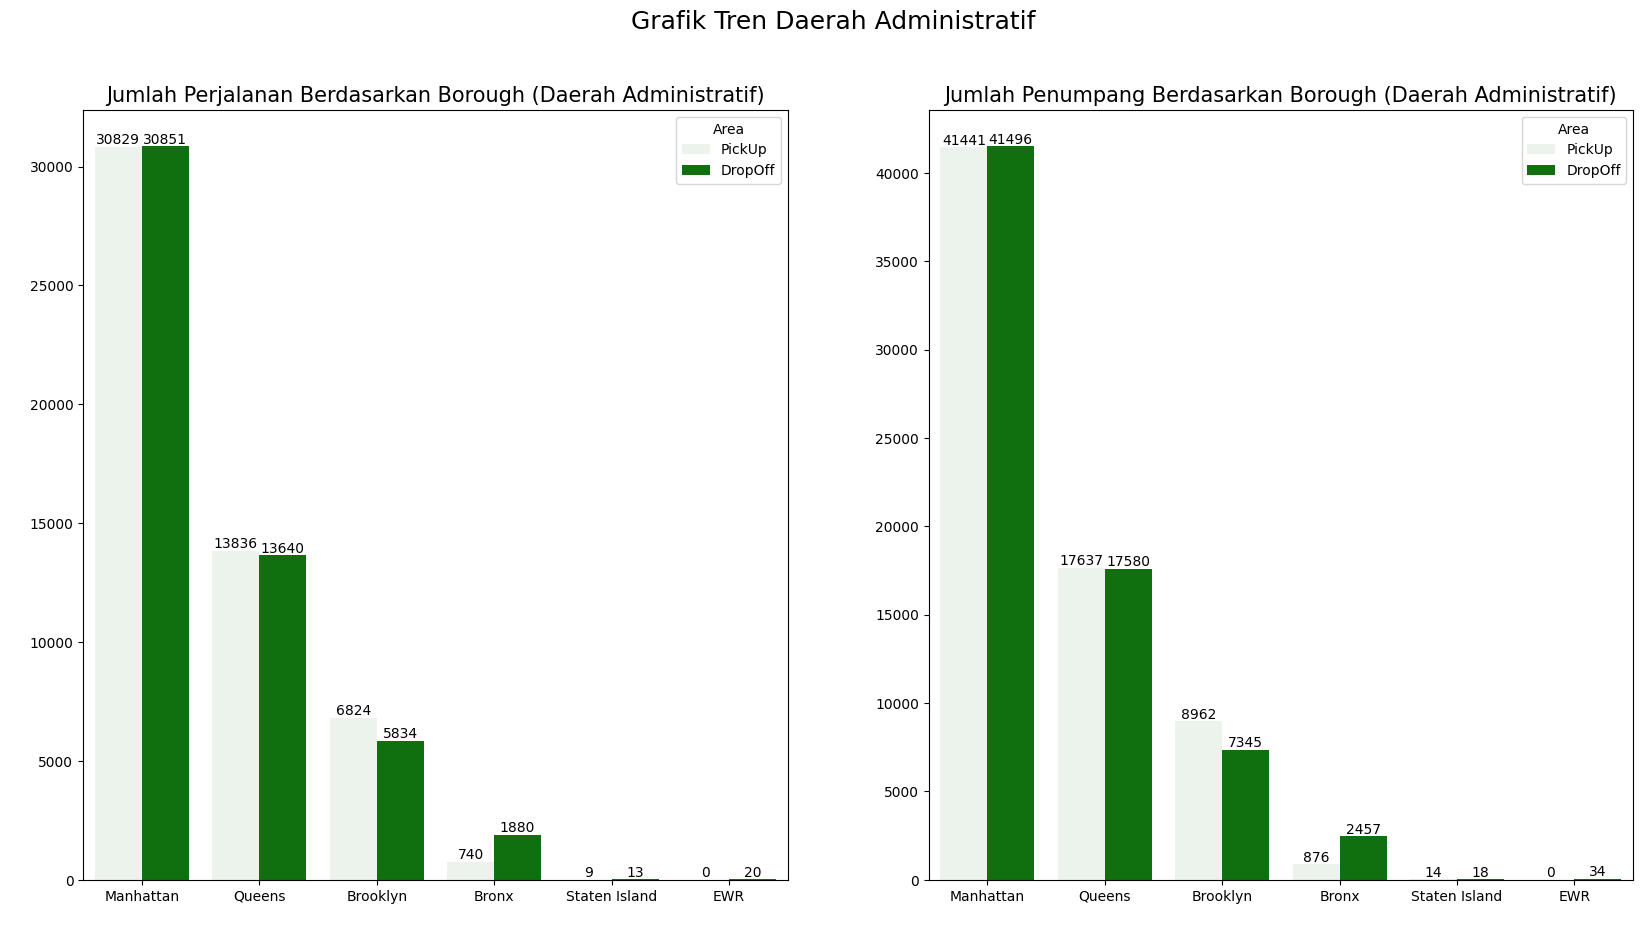

In [82]:
plt.figure(figsize=(20,10))

plt.suptitle('Grafik Tren Daerah Administratif\n', size=18)

plt.subplot(1,2,1) 
ax = sns.barplot(Borough, x='Borough', y='jumlah_perjalanan', hue='Area', estimator='sum', errorbar=('ci', 0), color = 'green')
ax.bar_label(ax.containers[0], label_type='edge', fmt=lambda x:f'{x:.0f}')
ax.bar_label(ax.containers[1], label_type='edge', fmt=lambda x:f'{x:.0f}')
plt.ylabel(' ')
plt.xlabel(' ')
plt.title('Jumlah Perjalanan Berdasarkan Borough (Daerah Administratif)', size=15)

plt.subplot(1,2,2) 
ax = sns.barplot(JumlahPenumpangBorough, x='Borough', y='passenger_count', hue='Area', estimator='sum', errorbar=('ci', 0), color = 'green')
ax.bar_label(ax.containers[0], label_type='edge', fmt=lambda x:f'{x:.0f}')
ax.bar_label(ax.containers[1], label_type='edge', fmt=lambda x:f'{x:.0f}')
plt.ylabel(' ')
plt.xlabel(' ')
plt.title('Jumlah Penumpang Berdasarkan Borough (Daerah Administratif)', size=15)

plt.show()

Dari grafik diatas terlihat bahwa, **Manhattan** menduduki peringkat pertama sebagai daerah terpopuler menurut penumpang berdasarkan jumlah perjalanan dan jumlah penumpang. Selain itu baik data *pick up* dan *drop off* tidak terlalu berbeda jauh. Hal ini menunjukkan bahwa, penumpang **Manhattan** sering melakukan perjalanan bolak-balik antara lokasi *pick up* dan *drop off*. Hal ini, dapat mencerminkan kegiatan sehari-hari seperti perjalanan ke *tempat kerja*, *pusat pembelajaran*, *restaurant*, atau *tempat hiburan lainnya* di **Manhattan**. Dari informasi terlihat bahwa kota **Manhattan** memiliki kehidupan yang aktif dan mobilitas tinggi.  

Lalu bagaimana karakteristik dari 3 daerah terbawah yaitu *Bronx, Staten Island, EWR* 

In [83]:
newyork_map = folium.Map(
    location=[40.71424396343662, -74.0079495976756],
    zoom_start=9
    )

manhattan_area = folium.Circle(
    location = [40.78238907305265, -73.97018409633229],     
    tooltip = 'Manhattan',
    radius=3000,          
)

queens_area = folium.Circle(
    location = [40.726733788362736, -73.79371620823713],     
    tooltip = 'Queens',
    radius=3000,          
)

broklyn_area = folium.Circle(
    location = [40.67878656577966, -73.94420256671974],     
    tooltip = 'Broklyn',
    radius=3000,          
)

bronx_area = folium.Circle(
    location=[40.84527021606007, -73.86718727448687],
    tooltip='Bronx',
    radius=3000,          
    color='red'
)

EWR_area = folium.Circle(
    location=[40.73609961907146, -74.17137122167034],
    tooltip='EWR',
    popup='(Newark Liberty International Airport)',
    radius=3000,          
    color='red'
)

statenisland_area = folium.Circle(
    location=[40.57637669194498, -74.14910369331551],
    tooltip='Staten Island',
    radius=3000,
    color='red'
)

manhattan_area.add_to(newyork_map)
queens_area.add_to(newyork_map)
broklyn_area.add_to(newyork_map)
bronx_area.add_to(newyork_map)
EWR_area.add_to(newyork_map)
statenisland_area.add_to(newyork_map)

newyork_map

Berdasarkan peta diatas, diketahui bahwa **lingkaran biru** merupakan top 3 daerah terpopuler menurut (Manhattan, Queens, Broklyn). Sedangkan **lingkaran merah** merupakan top 3 daerah tidak populer (Bronx, EWR, Staten Island).

Berdasarkan peta tersebut dapat menjelaskan **Karakteristik 3 Dareah Terendah Popularitasnya**

- **Bronx**, terletak dipaling ujung utara kota. Yang merupakan kota penyangga Manhattan. Hal ini dimungkinkan bahwa perjalanan yang dilakukan oleh penduduk kota Bronx, yaitu menuju keluar kota untuk bekerja, menuju bandara, dan lain sebagainya.

- **Staten Island** terletak di pulau terpisah dan dimungkinkan bahwa aksesibilitas transportasi menuju dan keluar dari pulau tersebut lebih terbatas dibanding daerah lain. 

- **EWR**, kepanjangan dari *Newark Liberty International Airport*, merupakan bandara internasional yang teletak di luar wilayah *New York* yaitu *New Jersey*. Sehingga dimungkinkan bahwa fokus perjalanan ini hanya menuju atau keluar bandara. 

Berdasarkan data *PickUp* dan *DropOff*  tertinggi yaitu *Manhattan* dilihat *Zone* apa yang mendominasi berdasarkan *jumlah_perjalanan*

In [84]:
# membuat dataframe yang berisi Pickup dan Drooff Borough berupa Manhattan
manhattanPU = df3[df3['PUBorough']=='Manhattan']
manhattanDO = df3[df3['DOBorough']=='Manhattan']

In [85]:
# Buat pengelompokkan Zona di Manhattan berdasarkan Banyak Perjalanan
# Data Zone Pick Up di Borough Manhattan 

Top10PerjalananPUManhattan = pd.DataFrame(manhattanPU.groupby('PUZone')[['count']].sum())
Top10PerjalananPUManhattan = Top10PerjalananPUManhattan.sort_values(by='count', ascending=False).reset_index().head(10)

# Data Top 10 Drop Off in Manhattan
Top10PerjalananDOManhattan = pd.DataFrame(manhattanDO.groupby('DOZone')[['count']].sum())
Top10PerjalananDOManhattan = Top10PerjalananDOManhattan.sort_values(by='count', ascending=False).reset_index().head(10)

In [86]:
# Buat pengelompokkan Zona di Manhattan berdasarkan Banyak Penumpang
# Data Zone Pick Up di Borough Manhattan 
Top10PUManhattan = pd.DataFrame(manhattanPU.groupby('PUZone')[['passenger_count']].sum())
Top10PUManhattan = Top10PUManhattan.sort_values(by='passenger_count', ascending=False).reset_index().head(10)

# Data Top 10 Drop Off in Manhattan
Top10DOManhattan = pd.DataFrame(manhattanDO.groupby('DOZone')[['passenger_count']].sum())
Top10DOManhattan = Top10DOManhattan.sort_values(by='passenger_count', ascending=False).reset_index().head(10)

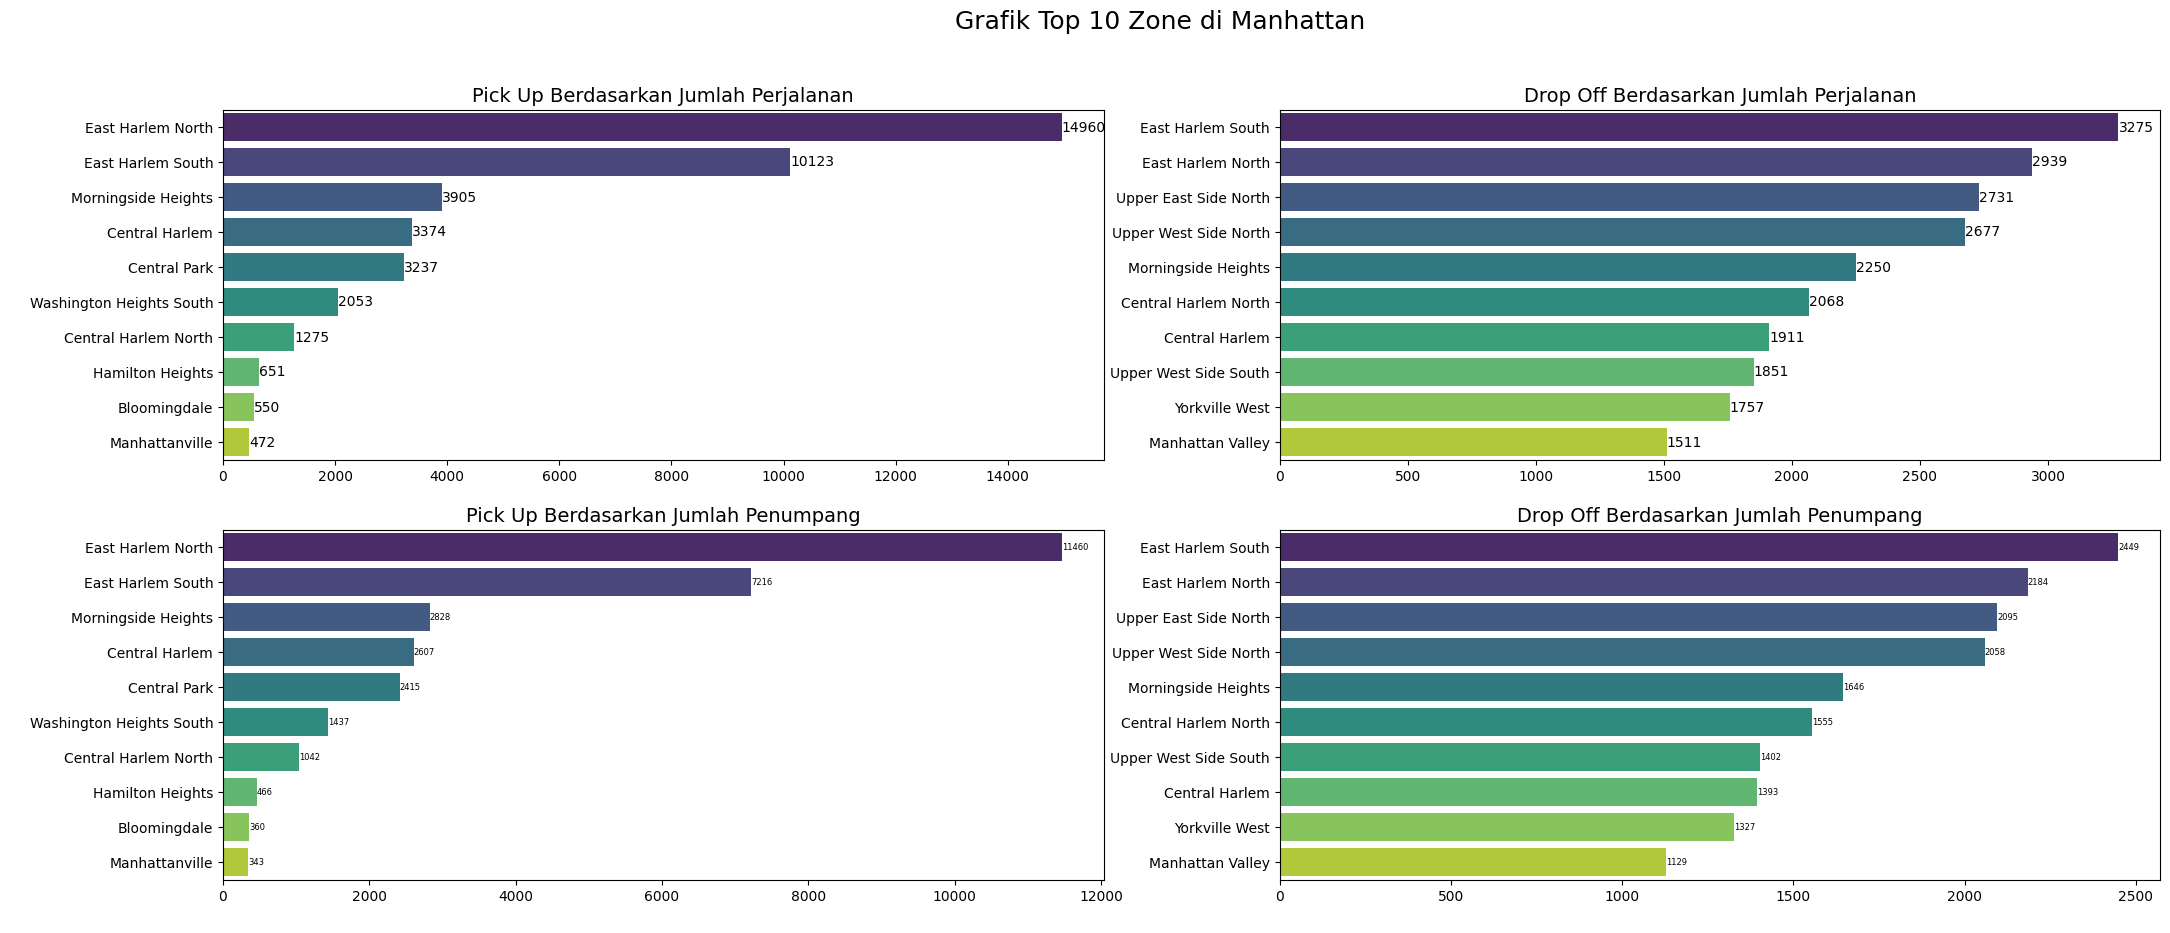

In [87]:
plt.figure(figsize=(25,10))

plt.suptitle('Grafik Top 10 Zone di Manhattan\n', size=18)

plt.subplot(2,2,1)
ax=sns.barplot(Top10PUManhattan, x='passenger_count', y='PUZone', palette='viridis')
ax.bar_label(ax.containers[0], label_type='edge', size=10, fmt=lambda x:f'{x:.0f}')
plt.title('Pick Up Berdasarkan Jumlah Perjalanan', size=14)
plt.xlabel(' ')
plt.ylabel(' ')

# plot diagram
plt.subplot(2,2,2)
ax=sns.barplot(Top10DOManhattan, x='passenger_count', y='DOZone', palette='viridis')
ax.bar_label(ax.containers[0], label_type='edge', size=10, fmt=lambda x:f'{x:.0f}')
plt.title('Drop Off Berdasarkan Jumlah Perjalanan', size=14)
plt.xlabel(' ')
plt.ylabel(' ')

# plot diagram
plt.subplot(2,2,3)
ax=sns.barplot(Top10PerjalananPUManhattan, x='count', y='PUZone', palette='viridis')
ax.bar_label(ax.containers[0], label_type='edge', size=6, fmt=lambda x:f'{x:.0f}')
plt.title('Pick Up Berdasarkan Jumlah Penumpang', size=14)
plt.xlabel(' ')
plt.ylabel(' ')

# plot diagram
plt.subplot(2,2,4)
ax=sns.barplot(Top10PerjalananDOManhattan, x='count', y='DOZone', palette='viridis')
ax.bar_label(ax.containers[0], label_type='edge', size=6, fmt=lambda x:f'{x:.0f}')
plt.title('Drop Off Berdasarkan Jumlah Penumpang', size=14)
plt.xlabel(' ')
plt.ylabel(' ')

plt.show()

Berdasarkan hasil pengelompokkan data (*jumlah perjalanan* dan *jumlah penumpang*) terlihat bahwa zone **East Harlem North** dan **East Harlem South** masih berada di top 5 utama. Keberadaan **East Harlem North** dan **East Harlem South** di urutan teratas menunjukkan bahwa zona ini memiliki daya tarik yang konsisten bagi penumpang dalam hal aktivitas transportasi. 

Berdasarkan data *PickUp* dan *DropOff* tertinggi yaitu *Manhattan* dilihat bagaimana pola perjalanan berdasarkan **trip type** nya

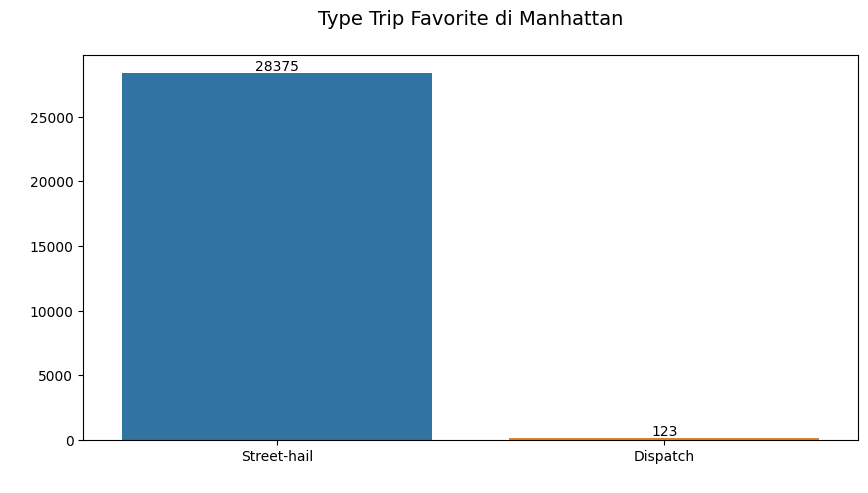

In [88]:
TripType = pd.DataFrame(df3[(df3['PUBorough'] == 'Manhattan') & (df3['DOBorough'] == 'Manhattan')]['trip_type'].value_counts()).reset_index()

plt.figure(figsize=(10,5))

plt.title('Type Trip Favorite di Manhattan\n', size=14)

ax = sns.barplot(TripType, y='count', x='trip_type')
ax.bar_label(ax.containers[0], label_type='edge', fmt=lambda x:f'{x:.0f}')
plt.ylabel(' ')
plt.xlabel(' ')

plt.show()

Tipe perjalanan yang paling sering dilakukan di **Manhattan** adalah **Street-hail** daripada **Dispatch**. Artinya, sebagian besar penumpang di Manhattan lebih sering memesan taksi langsung di jalan daripada menggunakan layanan taksi yang diatur oleh pihak ketiga atau melalui sistem dispatch.

## <font color='Gold'>Identifikasi Pembayaran Berdasarkan Borough</font>
Hal ini dapat memberikan wawasan tentang preferensi pembayaran penumpang dan tren dalam penggunaan teknologi pembayaran

**Karakterisitik Payment Type**
- A numeric code signifying how the passenger paid for the trip.
    - 1 = Credit card
    - 2 = Cash
    - 3 = No charge
    - 4 = Dispute   
    - 5 = Unknown
    - 6 = Voided trip

Selanjutnya akan dibahas tentang karakteristik metode pembayaran berdasarkan Borough

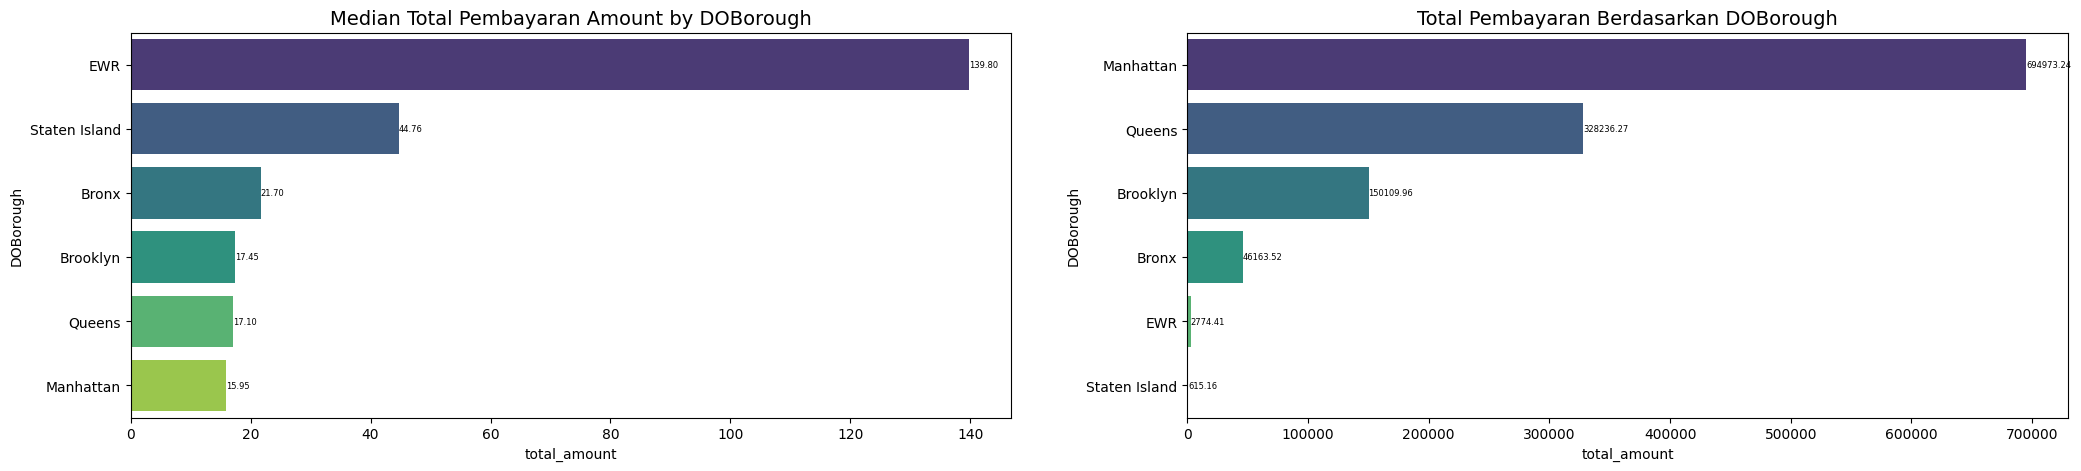

In [89]:
# Suporting Data 1
# melihat median total amount yang dibayarkan penumpang berdasarkan payment type
SD1_1 = df3.groupby(['DOBorough','payment_type'])[['total_amount']].median().reset_index()
SD1_1.sort_values(by='total_amount', ascending=False, inplace=True)

# Suporting Data 2
# melihat total amount yang dibayarkan penumpang berdasarkan payment type
SD1_2 = df3.groupby(['payment_type', 'DOBorough'])[['total_amount']].sum().reset_index().sort_values(by='total_amount', ascending=False)

# Membuat grafik
plt.figure(figsize=(25,5))

plt.subplot(1,2,1)
order1 = SD1_1.groupby('DOBorough')[['total_amount']].median().reset_index().sort_values(by='total_amount', ascending=False)
ax=sns.barplot(SD1_1, y='DOBorough', x='total_amount', order=order1['DOBorough'], estimator='median', errorbar=('ci', 0), palette='viridis')
ax.bar_label(ax.containers[0], label_type='edge', size=6, fmt=lambda x:f'{x:.2f}')
plt.title('Median Total Pembayaran Amount by DOBorough', size=14)

plt.subplot(1,2,2)
ax = sns.barplot(SD1_2, x='total_amount', y='DOBorough', palette='viridis', estimator= 'sum', errorbar=('ci', 0))
ax.bar_label(ax.containers[0], label_type='edge', size=6, fmt=lambda x:f'{x:.2f}')
plt.title('Total Pembayaran Berdasarkan DOBorough', size=14)

plt.show()

Berdasarkan grafik diatas terlihat bahwa median pembayaran **EWR** yang tertinggi, sedangkan untuk jumlah pembayaran di **Manhattan** yang paling tinggi. 

Median tertinggi di **EWR** menunjukkan bahwa tarif perjalanan di bandara cenderung lebih tinggi dibandingkan dengan daerah lain. Hal ini dapat disebabkan oleh beberapa faktor, seperti jarak yang lebih jauh antara bandara dan tujuan akhir penumpang atau biaya tambahan yang terkait dengan perjalanan bandara.

Sementara itu, total pembayaran yang tertinggi adalah **Manhattan** menunjukkan bahwa total pendapatan atau nilai transaksi perjalanan di **Manhattan** adalah yang terbesar dibandingkan dengan daerah lain. Hal ini dapat disebabkan oleh banyaknya aktivitas komersil dan pusat kegiatan di **Manhattan** serta tingginya permintaan transportasi di daerah tersebut.

Dalam konteks tarif perjalanan, perbedaan antara median di **EWR** dan total amount di **Manhattan** dapat mencerminkan adanya perjalanan dengan tarif yang lebih tinggi yaitu di bandara dibandingkan dengan perjalanan yang terjadi di **Manhattan**

Lalu bagaimana dengan proporsi penggunaan payment type disetiap Borough? Berikut penjelasannya.

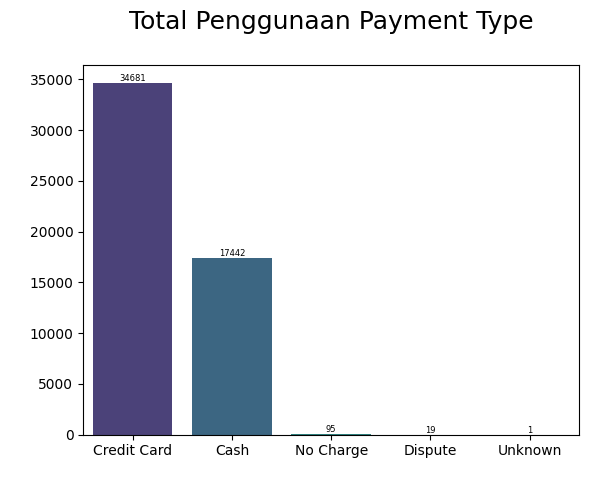

In [90]:
paymentType = pd.DataFrame(df3['payment_type'].value_counts()).reset_index()

ax = sns.barplot(paymentType, x='payment_type', y='count', estimator=sum, palette='viridis')
ax.bar_label(ax.containers[0], label_type='edge', size=6, fmt=lambda x:f'{x:.0f}')

plt.title('Total Penggunaan Payment Type\n', size=18)
plt.ylabel(' ')
plt.xlabel(' ')
plt.show()

In [91]:
df3['Credit_Card'] = np.where(df3['payment_type'] == 'Credit Card', 'Credit Card', 'Others')

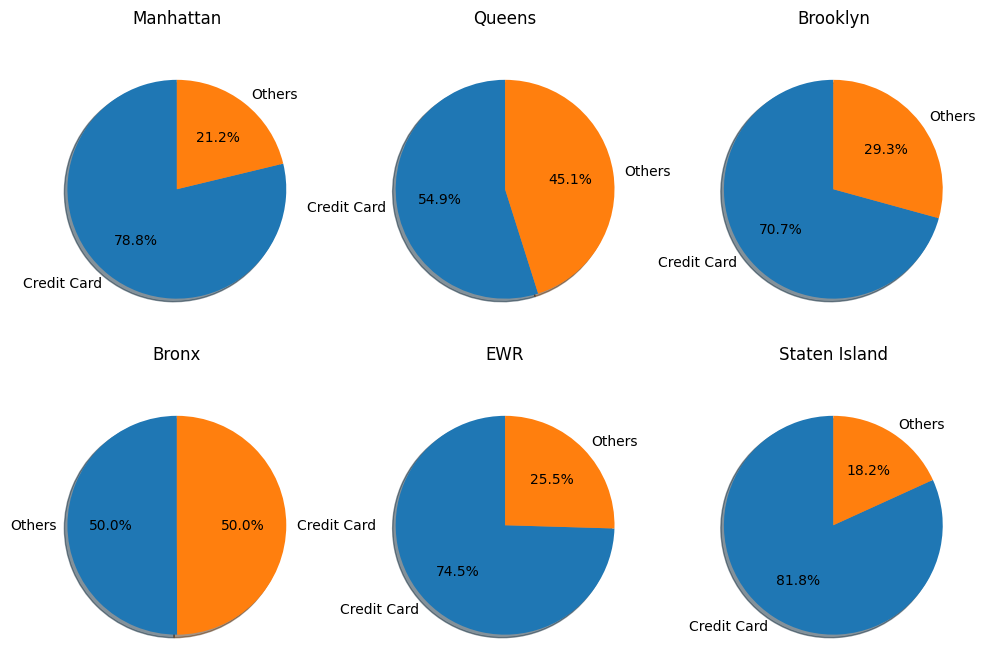

In [92]:
# Total amount di Manhattan berdasarkan Credit_Card
Credit_Card_manhattan = df3[df3['DOBorough']=='Manhattan'].groupby('Credit_Card')[['total_amount']].sum().reset_index()
Credit_Card_manhattan.sort_values(by='total_amount', ascending=False, inplace=True)

# Total amount di Queens berdasarkan Credit_Card
Credit_Card_queens = df3[df3['DOBorough']=='Queens'].groupby('Credit_Card')[['total_amount']].sum().reset_index()
Credit_Card_queens.sort_values(by='total_amount', ascending=False, inplace=True)

# Total amount di Brooklyn berdasarkan Credit_Card
Credit_Card_brooklyn = df3[df3['DOBorough']=='Brooklyn'].groupby('Credit_Card')[['total_amount']].sum().reset_index()
Credit_Card_brooklyn.sort_values(by='total_amount', ascending=False, inplace=True)

# Total amount di Bronx berdasarkan Credit_Card
Credit_Card_bronx = df3[df3['DOBorough']=='Bronx'].groupby('Credit_Card')[['total_amount']].sum().reset_index()
Credit_Card_bronx.sort_values(by='total_amount', ascending=False, inplace=True)

# Total amount di EWR berdasarkan Credit_Card
Credit_Card_EWR = df3[df3['DOBorough']=='EWR'].groupby('Credit_Card')[['total_amount']].sum().reset_index()
Credit_Card_EWR.sort_values(by='total_amount', ascending=False, inplace=True)

# Total amount di Staten Island berdasarkan Credit_Card
Credit_Card_SI = df3[df3['DOBorough']=='Staten Island'].groupby('Credit_Card')[['total_amount']].sum().reset_index()
Credit_Card_SI.sort_values(by='total_amount', ascending=False, inplace=True)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Plotting pie chart untuk Manhattan
axes[0, 0].pie(Credit_Card_manhattan['total_amount'], labels=Credit_Card_manhattan['Credit_Card'], autopct='%1.1f%%', shadow=True, startangle=90)
axes[0, 0].set_title('Manhattan\n')

# Plotting pie chart untuk Queens
axes[0, 1].pie(Credit_Card_queens['total_amount'], labels=Credit_Card_queens['Credit_Card'], autopct='%1.1f%%', shadow=True, startangle=90)
axes[0, 1].set_title('Queens\n')

# Plotting pie chart untuk Brooklyn
axes[0, 2].pie(Credit_Card_brooklyn['total_amount'], labels=Credit_Card_brooklyn['Credit_Card'], autopct='%1.1f%%', shadow=True, startangle=90)
axes[0, 2].set_title('Brooklyn\n')

# Plotting pie chart untuk Bronx
axes[1, 0].pie(Credit_Card_bronx['total_amount'], labels=Credit_Card_bronx['Credit_Card'], autopct='%1.1f%%', shadow=True, startangle=90)
axes[1, 0].set_title('Bronx\n')

# Plotting pie chart untuk EWR
axes[1, 1].pie(Credit_Card_EWR['total_amount'], labels=Credit_Card_EWR['Credit_Card'], autopct='%1.1f%%', shadow=True, startangle=90)
axes[1, 1].set_title('EWR\n')

# Plotting pie chart untuk Staten Island
axes[1, 2].pie(Credit_Card_SI['total_amount'], labels=Credit_Card_SI['Credit_Card'], autopct='%1.1f%%', shadow=True, startangle=90)
axes[1, 2].set_title('Staten Island\n')

# Menampilkan plot
plt.show()

- **Manhattan, EWR, Brooklyn, Staten Island:** Mayoritas pembayaran dilakukan menggunakan *Credit Card* dengan presentase diatas 70%. Hal ini menunjukkan bahwa para pengguna taksi di empat daerah tersebut memiliki ke-cenderungan lebih memilih **Credit Card** sebagai metode pembayaran yang praktis dan efisien. 

- **Queens, Bronx:** Mayoritas pembayaran dilakukan menggunakan *Credit Card* dengan prosentase sekitar 50%. Hal ini menunjukkan terdapat variasi metode pembayaran di area tersebut.

Lalu bagaimana dengan payment type berdasarkan hari? Adakah perbedaan diantaranya?

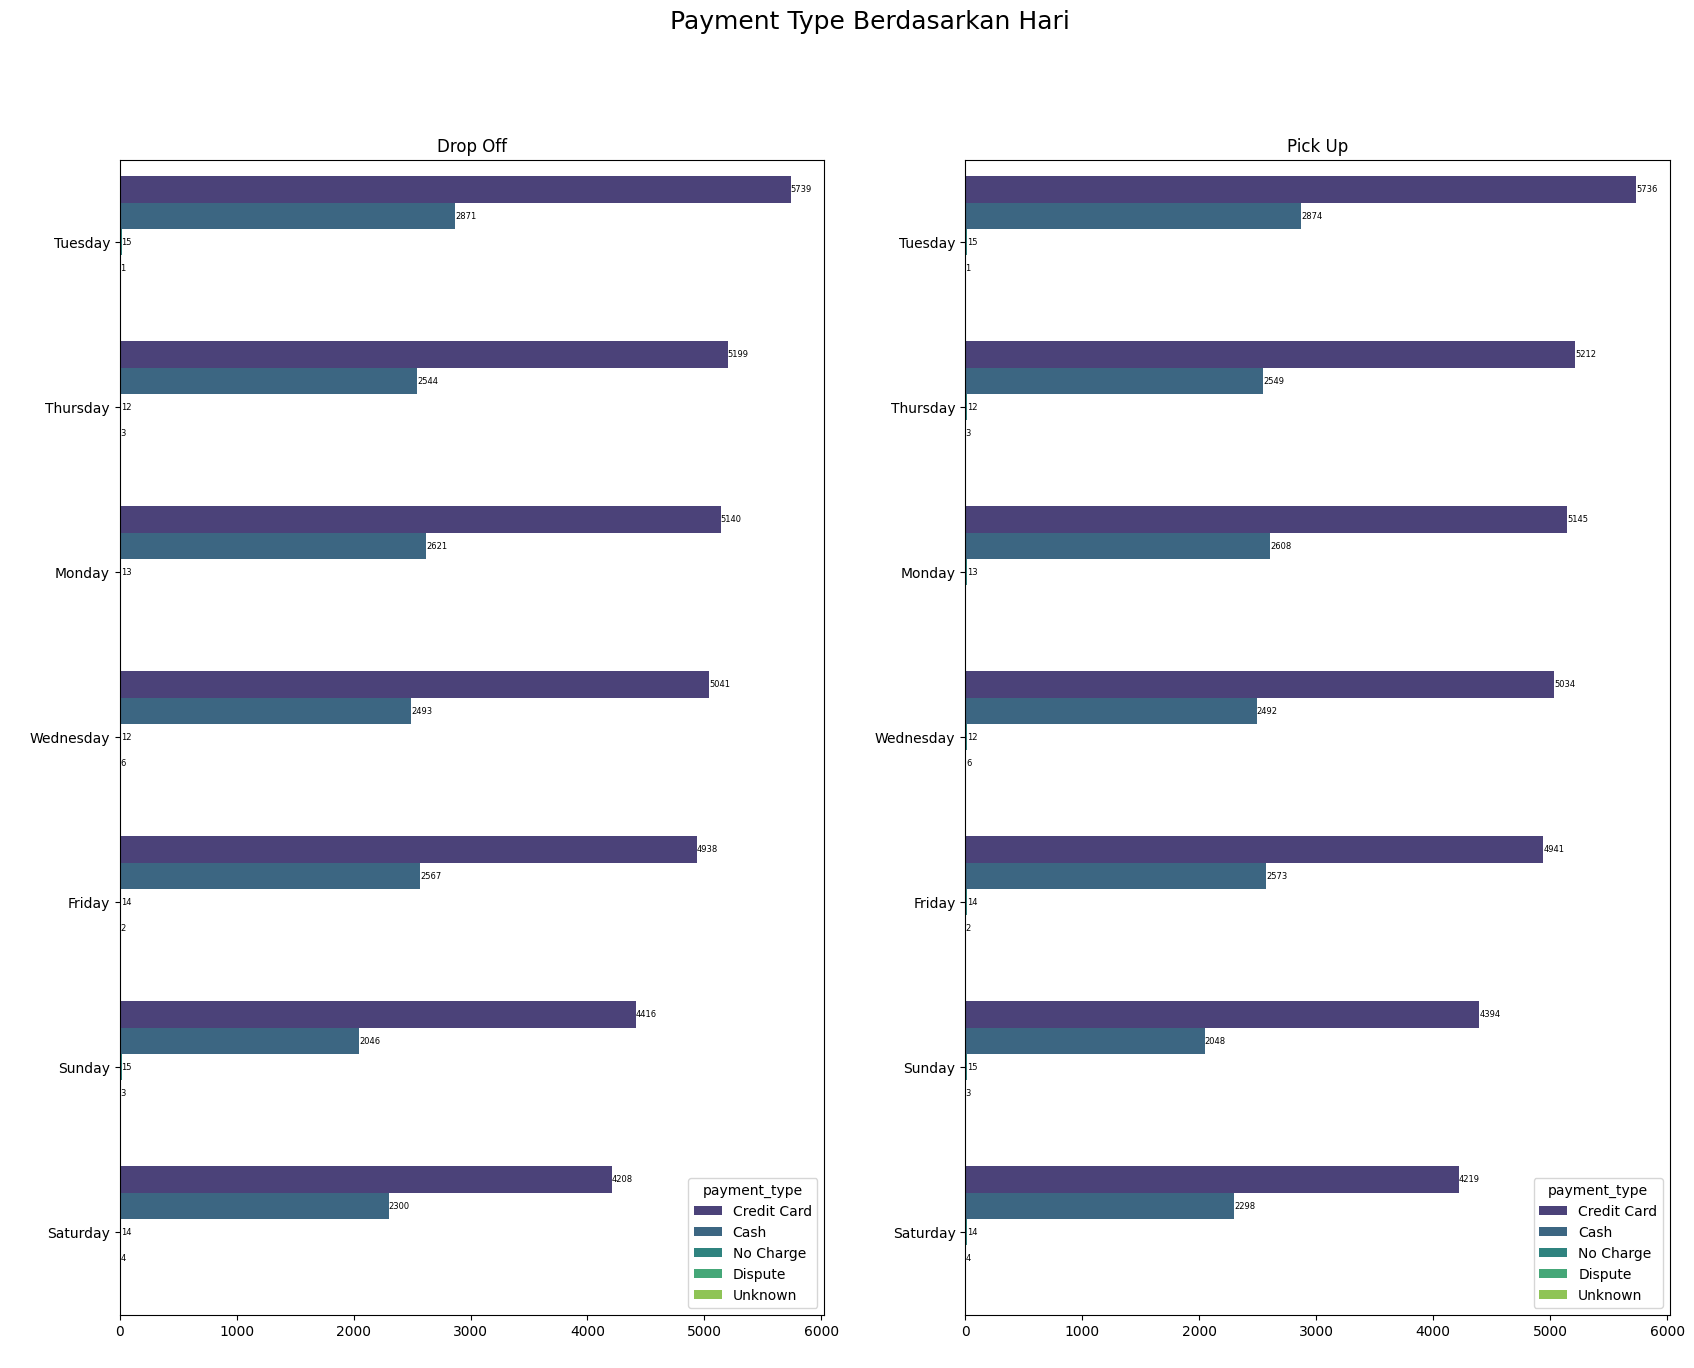

In [93]:
# dataframe payment type berdasarakan DOBorough
paymentType1 = df3.groupby(['payment_type', 'dropoff_day'])['count'].count().reset_index()
paymentType1.sort_values(by='count', ascending=False, inplace=True)

# dataframe payment type berdasarakan PUBorough
paymentType2 = df3.groupby(['payment_type', 'pickup_day'])['count'].count().reset_index()
paymentType2.sort_values(by='count', ascending=False, inplace=True)

# plot diagram
plt.figure(figsize=(20,15))
plt.suptitle('Payment Type Berdasarkan Hari', size=18)

plt.subplot(1,2,1)
ax=sns.barplot(paymentType1, x='count', y='dropoff_day', hue='payment_type', palette='viridis')
ax.bar_label(ax.containers[0], label_type='edge', size=6, fmt=lambda x:f'{x:.0f}')
ax.bar_label(ax.containers[1], label_type='edge', size=6, fmt=lambda x:f'{x:.0f}')
ax.bar_label(ax.containers[2], label_type='edge', size=6, fmt=lambda x:f'{x:.0f}')
ax.bar_label(ax.containers[3], label_type='edge', size=6, fmt=lambda x:f'{x:.0f}')
plt.ylabel(' ')
plt.xlabel(' ')
plt.title('Drop Off')

plt.subplot(1,2,2)
ax=sns.barplot(paymentType2, x='count', y='pickup_day', hue='payment_type', palette='viridis')
ax.bar_label(ax.containers[0], label_type='edge', size=6, fmt=lambda x:f'{x:.0f}')
ax.bar_label(ax.containers[1], label_type='edge', size=6, fmt=lambda x:f'{x:.0f}')
ax.bar_label(ax.containers[2], label_type='edge', size=6, fmt=lambda x:f'{x:.0f}')
ax.bar_label(ax.containers[3], label_type='edge', size=6, fmt=lambda x:f'{x:.0f}')
plt.ylabel(' ')
plt.xlabel(' ')
plt.title('Pick Up')

plt.show()

Dari tabel diatas terlihat bahwa dari hari *Tuesday* sampai *Saturday* frekuensi metode pembayaran yang paling sering digunakan adalah **credit card** dan **cash**, dengan metode **credit card** yang paling mendominasi baik untuk perjalanan *pick up* dan *drop off*. 

Hal ini dapat diartikan bahwa pengguna taksi cenderung memilih kemudahan dan kenyamanan pembayaran dengan **credit card** daripada **cash**. Adanya dominasi penggunaan metode pembayaran **credit card** juga dapat menunjukkan tingkat kepercayaan yang tinggi terhadap transaksi elektronik.

## <font color='gold'>Identifikasi Pola aktivitas antara **weekdays** dan **weekends**</font>
Hal ini dapat memberikan wawasan tentang perbedaan dalam tingkat aktivitas dan preferensi pengguna taksi pada hari *weekdays* dan *weekends*

Bagaimana pola aktivitas pengguna taksi di hari weekdays dan weekends?

In [94]:
# Menentukan daftar hari kerja
weekday_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Menambahkan kolom baru "days_mode" dengan kondisi hari kerja atau akhir pekan
df3.loc[df3['dropoff_day'].isin(weekday_list), 'days_mode'] = 'Weekdays'
df3.loc[~df3['dropoff_day'].isin(weekday_list), 'days_mode'] = 'Weekends'

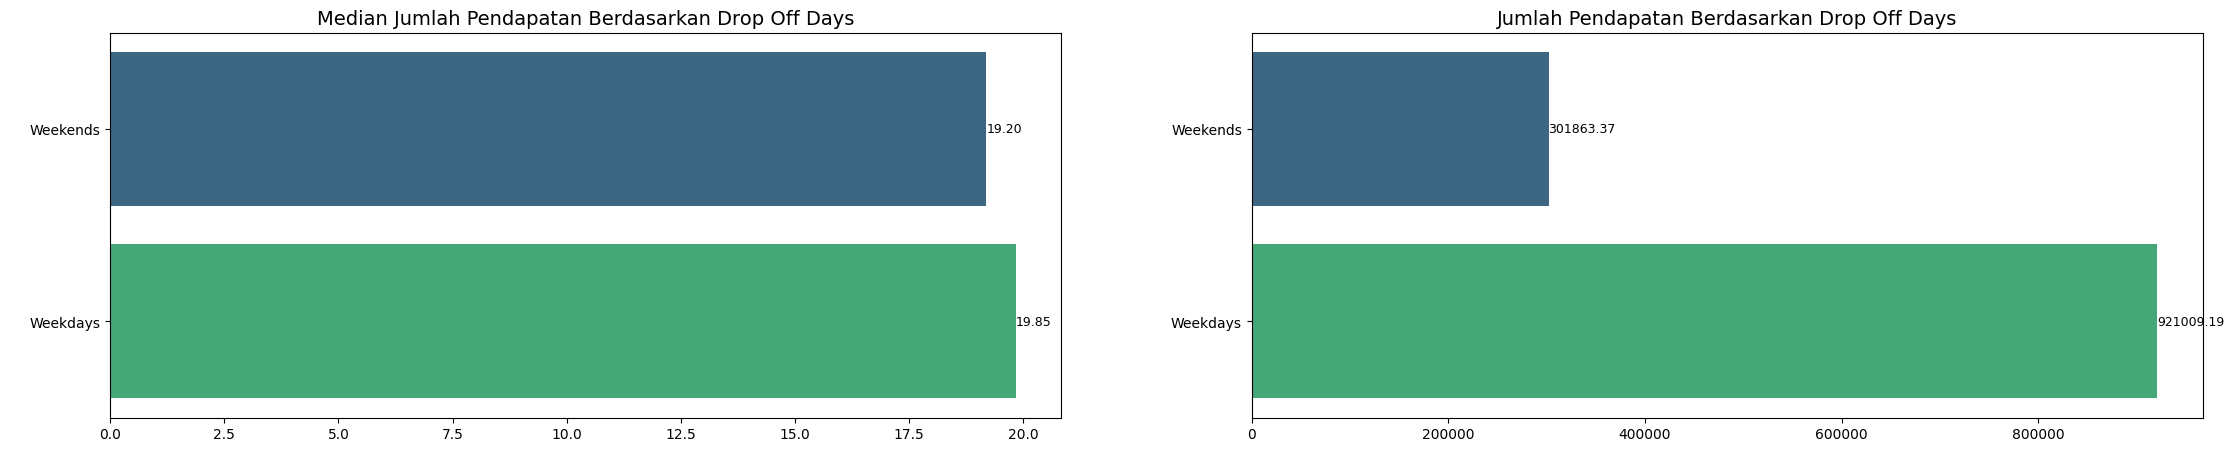

In [95]:
plt.figure(figsize=(27,5))
plt.subplot(1,2,1)
ax = sns.barplot(df3, x='total_amount', y='days_mode', palette='viridis', errorbar=('ci', 0), estimator='median')
ax.bar_label(ax.containers[0], label_type='edge', size=9, fmt=lambda x:f'{x:.2f}')
plt.ylabel(' ')
plt.xlabel(' ')
plt.title('Median Jumlah Pendapatan Berdasarkan Drop Off Days', size=14)

plt.subplot(1,2,2)
ax = sns.barplot(df3, x='total_amount', y='days_mode', palette='viridis', errorbar=('ci', 0), estimator='sum')
ax.bar_label(ax.containers[0], label_type='edge', size=9, fmt=lambda x:f'{x:.2f}')
plt.ylabel(' ')
plt.xlabel(' ')
plt.title('Jumlah Pendapatan Berdasarkan Drop Off Days', size=14)

plt.show()

- **Uji Statistik**
    - apakah median dari *weekdays* dan *weekends* terdapat perbedaan signifikan?
    - menentukan Ho dan H1:
        - H0: Median total amount pada weekdays sama dengan median total amount pada weekends.
        - H1: Median total amount pada weekdays berbeda dengan median total amount pada weekends.

In [96]:
from scipy.stats import mannwhitneyu

stat, pvalue = mannwhitneyu(
    df3[df3['days_mode'] == 'Weekdays']['total_amount'].median(),
    df3[df3['days_mode'] == 'Weekends']['total_amount'].median(),
    alternative = 'two-sided'
)

# Conclusion

if pvalue > 0.05:
    print(f'''
          pvalue = {pvalue:.5f}. pvalue > 0.05. Gagal menolak H0.
          Kita TIDAK punya cukup bukti untuk mengatakan 
          bahwa median total amounts weekdays  
          TIDAK SAMA dengan median total amount weekends
          (Mediannya TIDAK berbeda signifikan)
    ''')
else:
    print(f'''
          pvalue = {pvalue:.5f}. pvalue <= 0.05. Berhasil menolak H0.          
          Kita punya cukup bukti untuk mengatakan 
          bahwa median total amounts weekdays 
          SAMA dengan median total amount weekends
          (Mediannya berbeda signifikan)
          ''')


          pvalue = 1.00000. pvalue > 0.05. Gagal menolak H0.
          Kita TIDAK punya cukup bukti untuk mengatakan 
          bahwa median total amounts weekdays  
          TIDAK SAMA dengan median total amount weekends
          (Mediannya TIDAK berbeda signifikan)
    


Pada hari *weekdays* dan *weekends* **median** berbeda signifikan. Hal ini menunjukkan bahwa tarif yang dilakukan pada *weekdays* dan *weekends* tidak jauh berbeda.

**Jumlah pendapatan** *weekdays* 3.5 kali lipat dari *weekends*. Hal ini mengindikasikan bahwa orang-orang lebih cenderung menggunakan taksi untuk keperluan sehari-hari mungkin seperti, pergi ke kantor, sekolah, berbagai aktivitas rutin di hari kerja. 

In [97]:
df3.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'payment_type', 'trip_type', 'congestion_surcharge', 'PUBorough',
       'PUZone', 'PUservice_zone', 'DOBorough', 'DOZone', 'DOservice_zone',
       'pickup_day', 'dropoff_day', 'pickup_hour', 'dropoff_hour',
       'pickup_month', 'dropoff_month', 'trip_duration', 'count',
       'Credit_Card', 'days_mode'],
      dtype='object')

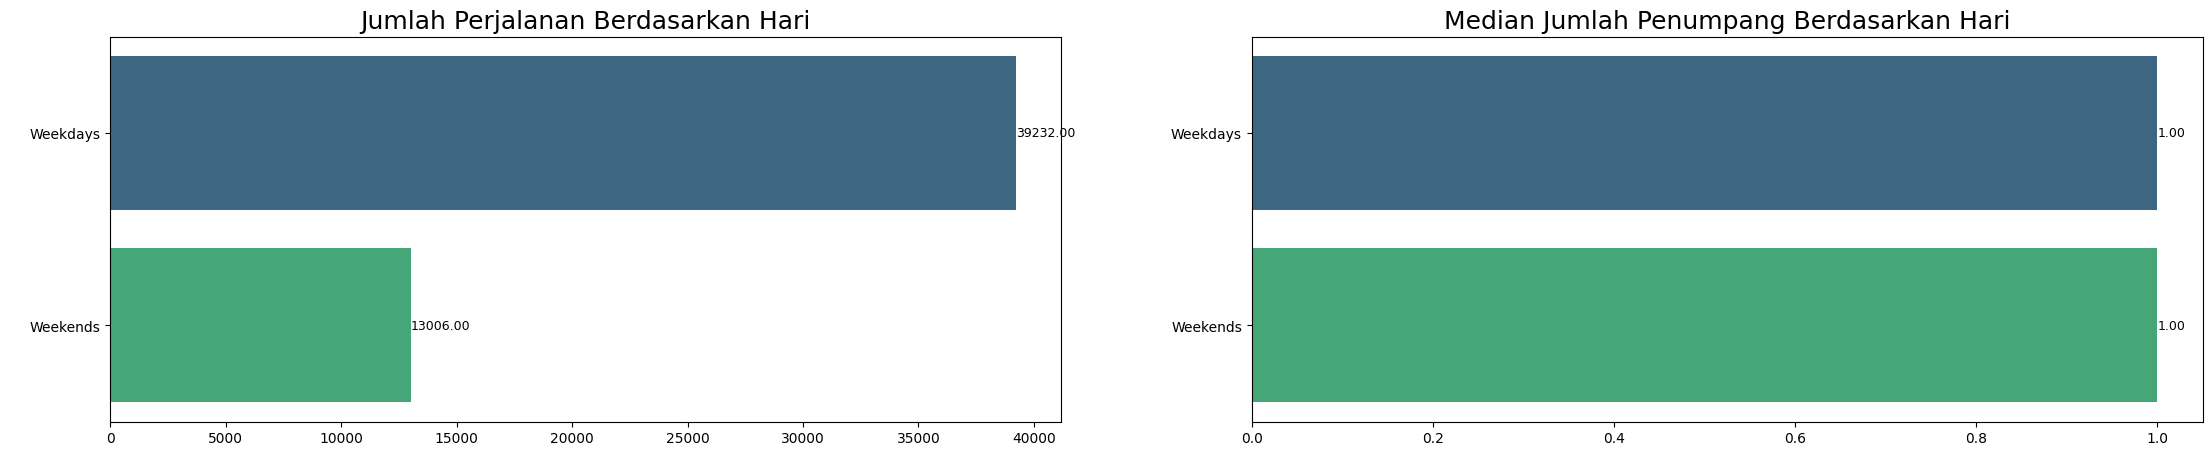

In [98]:
# Dataframe jumlah penumpang
jumlahPenumpang = pd.DataFrame(df3.groupby('days_mode')['count'].sum()).reset_index()
medianPenumpang = pd.DataFrame(df3.groupby('days_mode')['passenger_count'].median()).reset_index()

# Buat plot diagram
plt.figure(figsize=(27,5))
plt.subplot(1,2,1)
ax = sns.barplot(jumlahPenumpang, x='count', y='days_mode', palette='viridis', errorbar=('ci', 0))
ax.bar_label(ax.containers[0], label_type='edge', size=9, fmt=lambda x:f'{x:.2f}')
plt.ylabel(' ')
plt.xlabel(' ')
plt.title('Jumlah Perjalanan Berdasarkan Hari', size=18)

plt.subplot(1,2,2)
ax = sns.barplot(medianPenumpang, x='passenger_count', y='days_mode', palette='viridis', errorbar=('ci', 0))
ax.bar_label(ax.containers[0], label_type='edge', size=9, fmt=lambda x:f'{x:.2f}')
plt.ylabel(' ')
plt.xlabel(' ')
plt.title('Median Jumlah Penumpang Berdasarkan Hari', size=18)

plt.show()

Berdasarkan grafik di atas, terlihat bahwa *jumlah penumpang* taksi pada hari **weekdays** lebih banyak daripada hari **weekends**. Hal ini menunjukkan bahwa permintaan taksi cenderung lebih tinggi pada hari-hari kerja dibandingkan dengan hari libur. Selain itu, grafik juga menunjukkan bahwa sebagin besar penumpang taksi baik pada hari **weekdays** maupun **weekends** adalah penumpang tunggal. Ini menunjukkan bahwa sebagian besar perjalanan menggunakan taksi dilakukan oleh individu yang bepergian sendiri.

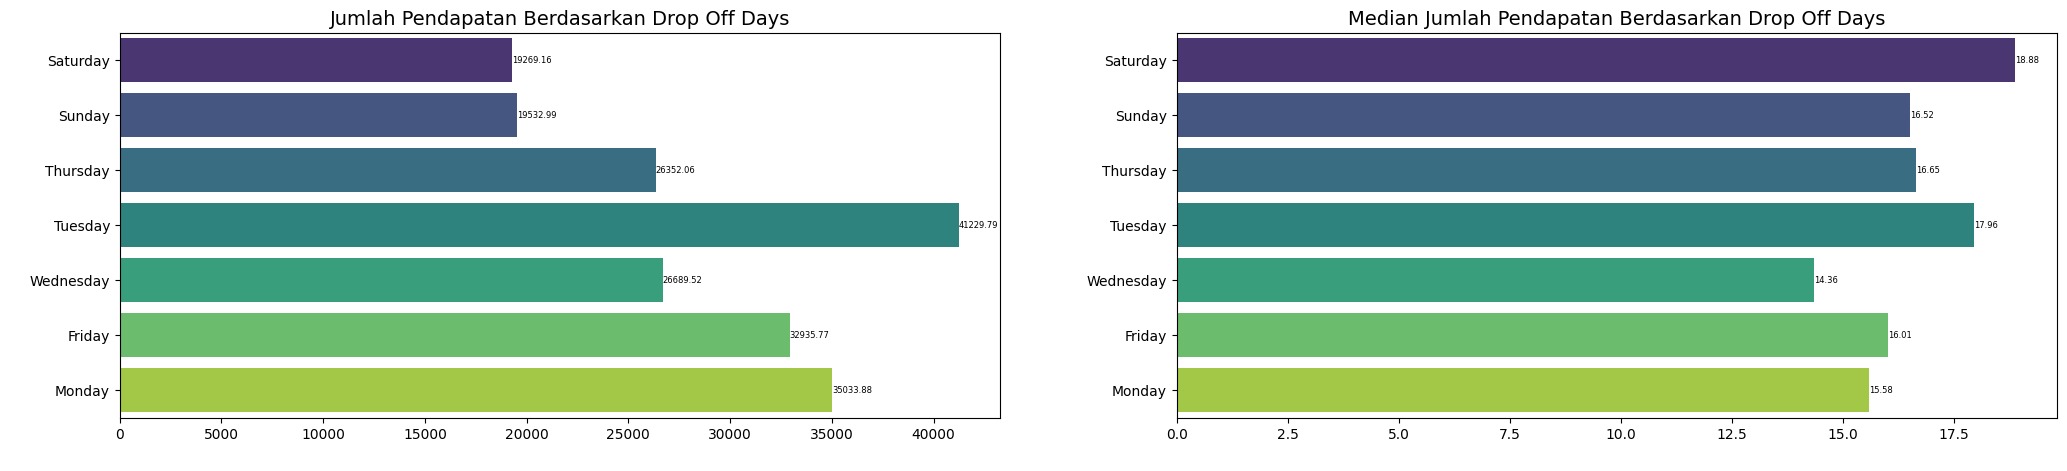

In [99]:
# Median total amount berdasarkan drop off days
median = manhattanDO.groupby(['payment_type', 'dropoff_day'])[['total_amount']].median().reset_index()
volume = manhattanDO.groupby(['payment_type', 'dropoff_day'])[['total_amount']].sum().reset_index()

order = ['Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Friday', 'Monday']

plt.figure(figsize=(25,5))

plt.subplot(1,2,1)
ax = sns.barplot(volume, x='total_amount', y='dropoff_day', order=order, palette='viridis', errorbar=('ci', 0))
ax.bar_label(ax.containers[0], label_type='edge', size=6, fmt=lambda x:f'{x:.2f}')
plt.ylabel(' ')
plt.xlabel(' ')
plt.title('Jumlah Pendapatan Berdasarkan Drop Off Days', size=14)

plt.subplot(1,2,2)
ax = sns.barplot(median, x='total_amount', y='dropoff_day', order=order, palette='viridis', errorbar=('ci', 0))
ax.bar_label(ax.containers[0], label_type='edge', size=6, fmt=lambda x:f'{x:.2f}')
plt.ylabel(' ')
plt.xlabel(' ')
plt.title('Median Jumlah Pendapatan Berdasarkan Drop Off Days', size=14)

plt.show()

Hal menarik yang perlu diperhatikan adalah, **Saturday** merupakan hari dengan median total amount tertinggi dan **Tuesday** merupakan hari dengan jumlah pendapatan tertinggi. Kedua hari tersebut mengindikasikan bahwa terdapat permintaan yang tinggi dan potensi pendapatan yang baik bagi perusahaan taksi di hari tersebut.

Selanjutnya akan dilihat bagaimana median total amount berdasarkan RatecodeID. Hal ini berguna untuk melihat pola tarif pembayaran di akhir perjalanan

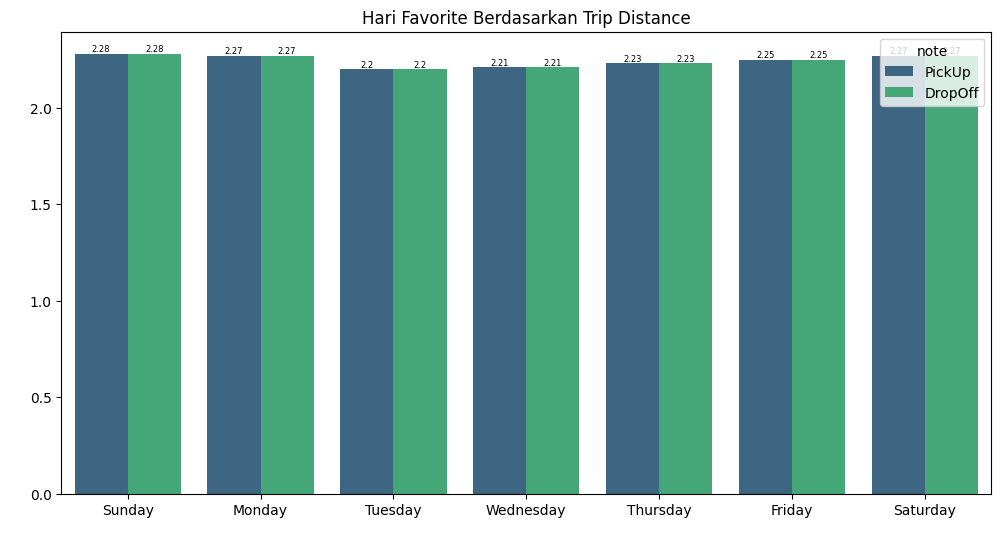

In [100]:
# buat kolom days untuk pick up dan drop off
daysPU = df3.groupby('pickup_day')[['trip_distance']].median().reset_index().rename(columns={'trip_distance' : 'count', 'pickup_day' : 'day'})
daysPU['note'] = 'PickUp'
daysDO = df3.groupby('dropoff_day')[['trip_distance']].median().reset_index().rename(columns={'trip_distance' : 'count', 'dropoff_day' : 'day'})
daysDO['note'] = 'DropOff'

# kolom gabungan antara daysPU dan daysPD
days = pd.concat([daysPU,daysDO])

# membuat plot diagram
plt.figure(figsize=(12,6))

plt.title('Hari Favorite Berdasarkan Trip Distance')

sorted_day = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'] 
plot=sns.barplot(days, x='day', y='count', hue='note', order= sorted_day, palette='viridis')
for container in plot.containers:
    plot.bar_label(container, size=6, label_type='edge')

plt.ylabel(' ')
plt.xlabel(' ')

plt.show()

Pada hari **Sunday** dan **Saturday**, terdapat perjalanan dengan jarak tempuh *(trip distance)* yang lebih tinggi dibandingkan hari-hari lainnya. Hal ini dapat mengindikasikan adanya kegiatan atau aktivitas khusus yang dilakukan pada hari libur, seperti perjalanan jauh atau rekreasi di luar kota. Dengan demikian, pada hari **Sunday** dan **Saturday**, penumpang cenderung melakukan perjalanan yang lebih jauh menggunakan taksi. 

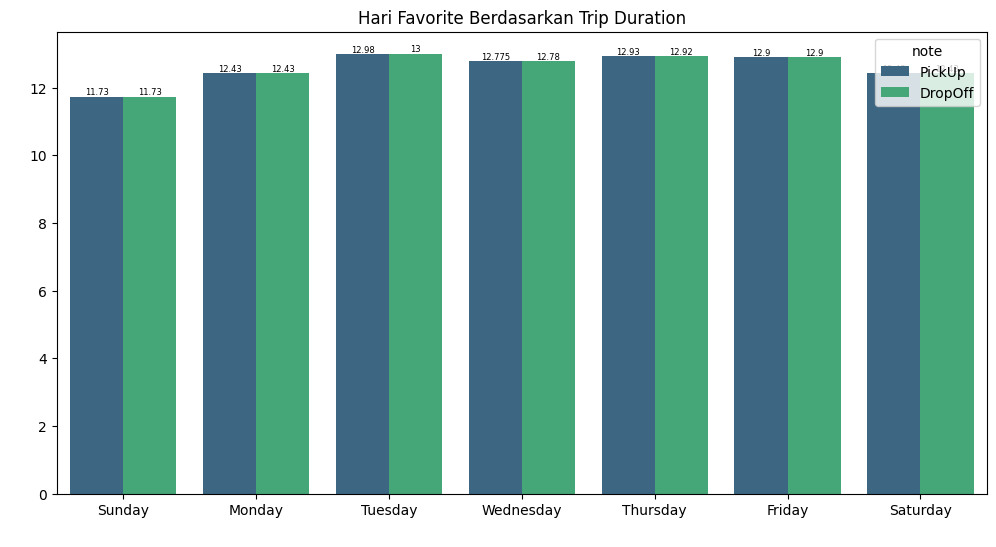

In [101]:
# buat kolom days untuk pick up dan drop off
daysPU = df3.groupby('pickup_day')[['trip_duration']].median().reset_index().rename(columns={'trip_duration' : 'count', 'pickup_day' : 'day'})
daysPU['note'] = 'PickUp'
daysDO = df3.groupby('dropoff_day')[['trip_duration']].median().reset_index().rename(columns={'trip_duration' : 'count', 'dropoff_day' : 'day'})
daysDO['note'] = 'DropOff'

# kolom gabungan antara daysPU dan daysPD
days = pd.concat([daysPU,daysDO])

# membuat plot diagram
plt.figure(figsize=(12,6))

plt.title('Hari Favorite Berdasarkan Trip Duration')

sorted_day = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'] 
plot=sns.barplot(days, x='day', y='count', hue='note', order= sorted_day, palette='viridis')
for container in plot.containers:
    plot.bar_label(container, size=6, label_type='edge')

plt.ylabel(' ')
plt.xlabel(' ')

plt.show()

Berdasarkan nilai median dari hari dengan **trip duration**, menunjukkan bahwa pada hari **Monday** hingga **Friday** terdapat perjalanan dengan **trip duration** yang lebih tinggi dibanding hari lainnya. Hal ini dapat diartikan bahwa pada hari kerja, seperti **Monday** hingga **Friday**, terdapat perjalanan yang lebih panjang atau membutuhkan waktu yang lebih lama. Kemungkinan hal ini disebabkan karena kemacetan jalanan kota.

## <font color='gold'>Identifikasi Pola aktivitas berdasarkan waktu</font>
Hal ini dapat mengidentifikasi hari-hari tertentu di mana aktivitas pickup dan dropoff meningkat atau menurun secara signifikan. 

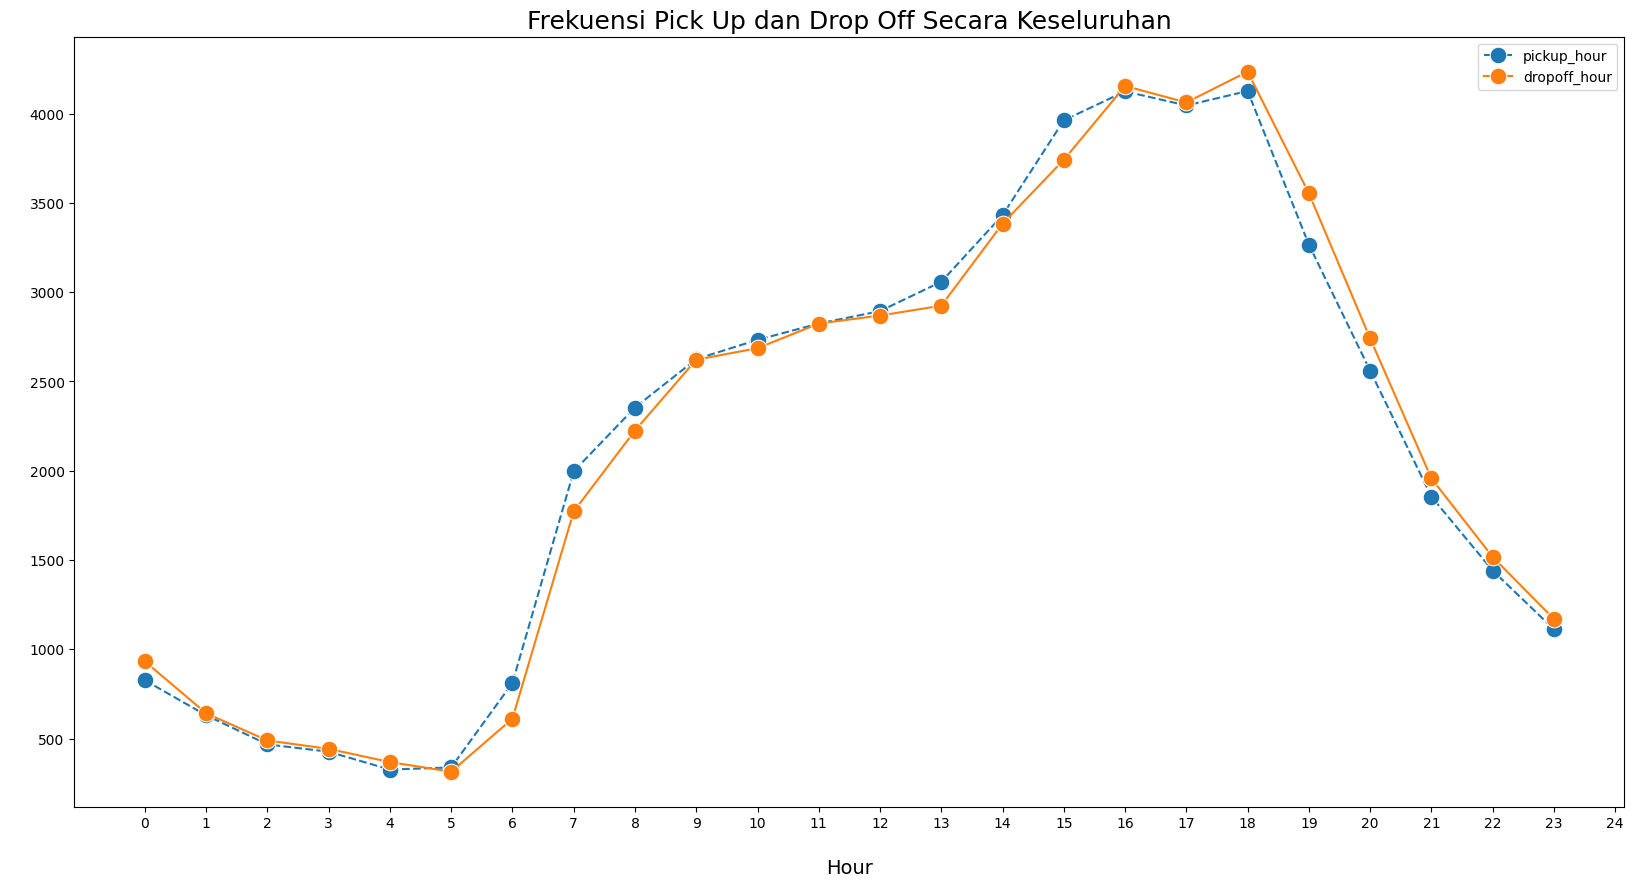

In [102]:
# buat line plot
PUhour = pd.DataFrame(df3.groupby('pickup_hour')['lpep_pickup_datetime'].count())
PUhour.reset_index(inplace=True)
PUhour.rename(columns={'lpep_pickup_datetime' : 'count'}, inplace=True)

# buat line plot
DOhour = pd.DataFrame(df3.groupby('dropoff_hour')['lpep_pickup_datetime'].count())
DOhour.reset_index(inplace=True)
DOhour.rename(columns={'lpep_pickup_datetime' : 'count'}, inplace=True)

# Buat plot diagram
plt.figure(figsize=(20,10))

plt.title('Frekuensi Pick Up dan Drop Off Secara Keseluruhan', size=18)
sns.lineplot(PUhour, x='pickup_hour', y='count', label='pickup_hour', marker='o', markersize=12, linestyle="--")
sns.lineplot(DOhour, x='dropoff_hour', y='count', label='dropoff_hour', marker='o', markersize=12, linestyle="-")
plt.xticks(range(0,25,1))
plt.ylabel(' ')
plt.xlabel('\nHour', size=14)

plt.show()

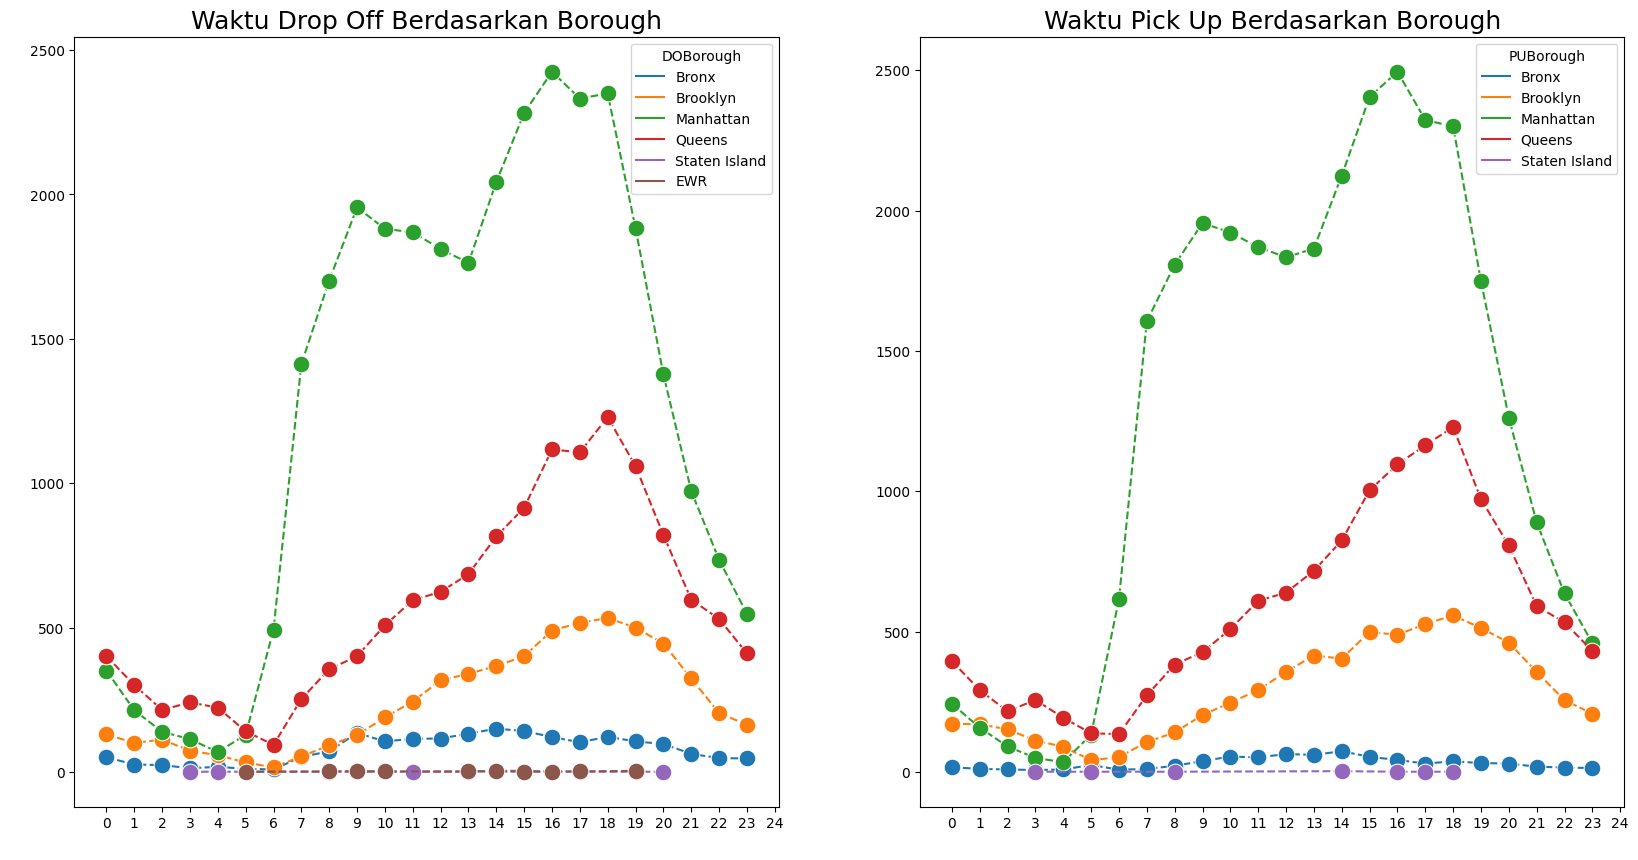

In [103]:
# Data drop off
cb = pd.DataFrame(df3.groupby(['dropoff_hour','DOBorough'])['count'].sum()).reset_index()
# Data pick up
cb2 = pd.DataFrame(df3.groupby(['pickup_hour','PUBorough'])['count'].sum()).reset_index()

# plot diagram
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.lineplot(cb, x='dropoff_hour', y='count', hue='DOBorough', marker='o', markersize=12, linestyle="--")
plt.title('Waktu Drop Off Berdasarkan Borough', size=18)
plt.ylabel(' ')
plt.xlabel(' ')
plt.xticks(range(0,25,1))

plt.subplot(1,2,2)
sns.lineplot(cb2, x='pickup_hour', y='count', hue='PUBorough', marker='o', markersize=12, linestyle="--")
plt.title('Waktu Pick Up Berdasarkan Borough', size=18)
plt.ylabel(' ')
plt.xlabel(' ')
plt.xticks(range(0,25,1))
plt.show()

Waktu pickup dan dropoff secara keseluruhan dan berdasarkan *Borough*, frekuensi **pick up** dan **drop off** mengalami pola yang menarik. Terlihat bahwa jumlah perjalanan naik pada pukul 5 pagi dan mencapi puncaknya pada pukul 6 sore. Setelah itu, jumlah perjalanan mulai menurun sekitar 1/3 dari jumlah puncaknya. Hal ini mengindikasikan bahwa sebagian besar perjalanan dengan taksi dilakukan pada **pagi** dan **sore** hari, yang mungkin terikat dengan watu berangkat dan pulang kerja. 

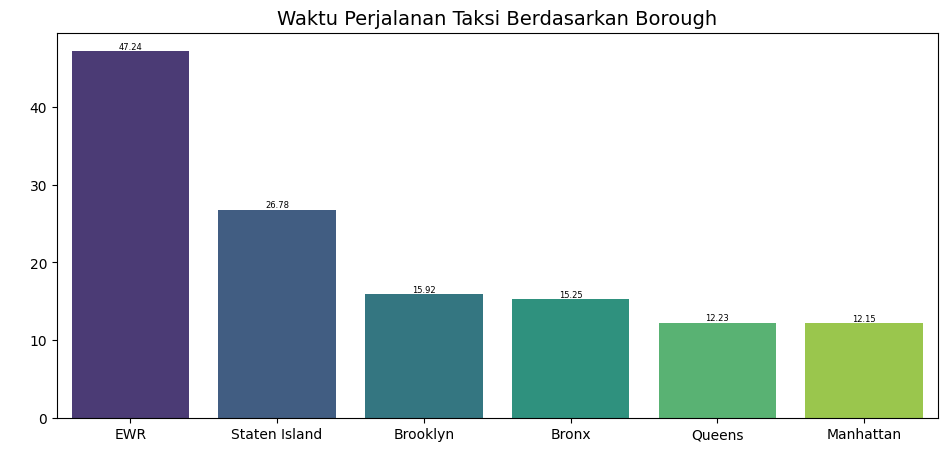

In [104]:
# Rata-rata keseluruhan drop off berdasarkan Borough
medianDO = pd.DataFrame(df3.groupby('DOBorough')['trip_duration'].median()).reset_index()
medianDO.sort_values(by='trip_duration', ascending=False, inplace=True)

# buat plot 
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
ax = sns.barplot(medianDO, x='DOBorough', y='trip_duration', palette='viridis', errorbar=('ci', 0))
ax.bar_label(ax.containers[0], label_type='edge', size=6, fmt=lambda x:f'{x:.2f}')
plt.ylabel(' ')
plt.xlabel(' ')
plt.title('Waktu Perjalanan Taksi Berdasarkan Borough', size=14)
plt.show()

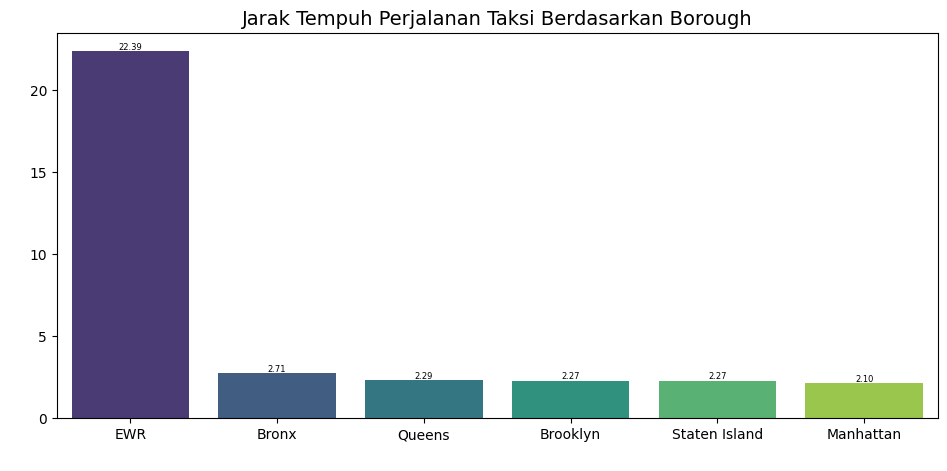

In [105]:
# Rata-rata keseluruhan drop off berdasarkan Borough
medianDO = pd.DataFrame(df3.groupby('DOBorough')['trip_distance'].median()).reset_index()
medianDO.sort_values(by='trip_distance', ascending=False, inplace=True)

# buat plot 
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
ax = sns.barplot(medianDO, x='DOBorough', y='trip_distance', palette='viridis', errorbar=('ci', 0))
ax.bar_label(ax.containers[0], label_type='edge', size=6, fmt=lambda x:f'{x:.2f}')
plt.ylabel(' ')
plt.xlabel(' ')
plt.title('Jarak Tempuh Perjalanan Taksi Berdasarkan Borough', size=14)
plt.show()

Berdasarkan data diatas, terlihat bahwa **EWR** memiliki median waktu tempuh dan median jarak perjalanan paling tinggi. Hal ini dimungkinkan, jika kita melihat lokasi **EWR** berada di luar wilayah **New York** yaitu berada di **Ner Jersey**. 

Selain itu, **waktu tempuh** di **Manhattan** paling rendah dibandingkan dengan Borough lainnya. Hal ini menunjukkan bahwa mayoritas perjalanan di **Manhattan** memiliki jarak yang relatif lebih pendek dan dapat diselesaikan dengan cepat. Ini mungkin disebabkan oleh keberadaan infrastruktur yang baik di daerah tersebut.

Lain hal nya dengan, **jarak tempuh** di **Staten Island** juga tergolong rendah dibandingan dengan borough lainnya. Hal ini dapat diartikan bahwa perjalanan di **Staten Island** cenderung dilakukan dilakukan di dalam pulau sendiri atau perjalanan antara **Staten Island** dengan pulau terdekat, sehingga jawak tempunya tidak terlalu jauh.

****
# **Kesimpulan:**
****

### 1. Daerah mana yang paling banyak pemesanan taksi baik *pickup* maupun *dropoff*?

Tren penumpang berdasarkan *pickup* dan *dropoff* terlihat bahwa daerah **Manhattan** dengan zone paling populer untuk penumpang dengan perjalanan *pick up* dan *drop off* berada di zona **East Harlem North** dan **East Harlem South** dengan tipe perjalanan **Street-hail**. Hal ini dapat memberikan wawasan tentang pusat aktivitas atau tujuan yang populer bagi penumpang

## 2. Metode pembayaran apa yang paling sering digunakan penumpang?

Hal yang menarik terjadi pada semua Borough, terutama di **Manhattan, Brooklyn, EWR, dan Staten Island** dimana metode pembayaran yang paling sering digunakan adalah **Credit Card**. Sedangkan di **Bronx dan Queens**, terdapat variasi dalam pemilihan metode pembayaran antara **Credit Card** dan **Cash**. Selain itu, baik untuk perjalanan *pickup* dan *dropoff*, metode pembayaran yang paling dominan masih menggunakan **Credit Card**

## 3. Apakah ada pola aktivitas yang berbeda antara *weekdays* dan *weekend*?

Berdasarkan analisis, terdapat perbedaan jumlah pendapatan antara hari **weekdays** dan **weekends**. Jumlah Pendapatan pada hari **weekdays** sebesar 3.5 kali lebih tinggi daripada hari **weekends**. Hal ini dapat disebabkan oleh jumlah perjalanan yang lebih banyak pada hari **weekdays**. Perjalanan cenderung dilakukan oleh individu yang bepergian sendirian.  Selain itu, durasi perjalanan pada hari **weekdays** cenderung lebih lama daripada hari **weekends**, yang juga berkontribusi terhadap pendapatan yang lebih tinggi. Namun, pada hari **weekends** terdapat kecenderungan penumpang untuk melakukan perjalanan dengan jarak yang lebih jauh.

## 4. Bagaimanakah preferensi waktu penumpang?

Pola perjalanan taksi cenderung terkait dengan aktivitas sehari-hari, hal ini di buktikan dengan jumlah perjalanan *pick up* dan *drop off* meningkat dari pukul 5 pagi hingga 6 sore. Selain itu, perjalanan dengan tujuan **EWR** membutuhkan waktu tempuh yang lebih lama disebabkan oleh jarak yang lebih jauh, mengingat lokasi **EWR** berada di luar wilayah **New York**. Informasi ini dapat membantu perushaan pengelola taksi dalam mengatur dan mengoptimalkan pelayaan mereka, terutama dalam hal alokasi waktu tunggu.

****
# **Rekomendasi**
****

#### 1. Fokus pada daerah populer

    - Perusahaan dapat mengalokasikan lebih banyak armada di daerah Manhattan dengan zona East Harlem North dan East Harlem South

#### 2. Peningkatan layanan *Street-hail*

    - Tipe perjalanan ini dominan, diharapkan perushaan meningkatkan layanan dan ketersediaan taksi di jalan.

#### 3. Memberikan promosi pembayaran

    - Perusahaan dapat bekerja sama dengan provider mitra credit card untuk memberikan penawaran diskon atau reward khusus bagi para penumpang.

#### 4. Strategi pemasaran yang berbeda untuk setiap **Borough**


    - Untuk dihari weekdays, promosi lebih kepada individu yang melakukan perjalanan seorang diri seperti, mahasiswa, pekerja atau profesional, yang melakukan perjalanan rutin.
    - Untuk weekends perusahan dapat menargetkan kelompok pelanggan yang condong untuk bepergian tujuan rekreasi.

#### 5. Penawaran paket tour wisata

    - Seperti perjalanan wisata, perjalanan ke acara khusus, atau penjemputan dari tempat rekreasi populer. Diharapkan dapat meningkatkan minat pelanggan untuk menggunakan taksi.

#### 6. Pengaturan ketersediaan taksi

    - Perusahaan dapat mengatur jumlah taksi yang tersedia dan waktu tunggu di area-area dengan tingkat peminat yang tinggi diantara pukul 5 pagi hingga 6 pagi.